This notebook contains the comparison between the eulogies pre and post Revolution

# 1. Load and imports

In [1]:
from eda import *
from pre_process import *
from percent import *
from adverbs_eda import *
from itertools import chain
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel
from transformers import CamembertModel
from bertopic import BERTopic




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import plotly.express as px
import plotly.offline as pyo
import kaleido


pyo.init_notebook_mode()


/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/Documents/COURS_EPFL/MA4-2022/PDS/eloge_academie/Code/Comparison/eda.py:13: FutureWarning: The squeeze ar

In [2]:
%load_ext autoreload

%autoreload 2

In [3]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.max_columns', 200)

In [4]:
df = pd.read_csv('./../../Data/Dataframes/eulogies.csv')

In [5]:
#Keeping the eulogies that interest us
df = df[((df['Annee']>1793) & (df['Annee']<1832))|(df['Auteur'] =='Condorcet')]

# 2. First axis : basic statistics

## Removing \n, \t, non-useful spaces

In [6]:
#Removing encryption characters

df['Eloge'] = df['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

In [7]:
df.head(1)

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## a. Number of eulogies

In [8]:
print('Il y a ' + str(df.shape[0]) + ' éloges') 
print('Il y a ' + str(df[df['Annee']<1793].shape[0]) + ' éloges avant la Révolution française')
print('Il y a ' + str(df[df['Annee']>=1793].shape[0]) + ' éloges après la Révolution française')

Il y a 144 éloges
Il y a 79 éloges avant la Révolution française
Il y a 65 éloges après la Révolution française


In [9]:
print('Il y a ' + str(df['Auteur'].nunique()) + ' auteurs différentes')
print('Il y a ' + str(df[df['Annee']<1793]['Auteur'].nunique()) + ' auteur avant la Révolution')
print('Il y a ' + str(df[df['Annee']>=1793]['Auteur'].nunique()) + ' auteurs après la Révolution')

Il y a 12 auteurs différentes
Il y a 1 auteur avant la Révolution
Il y a 11 auteurs après la Révolution


## b. Number of eulogies per year

Text(0, 0.5, "Nombre d'éloges")

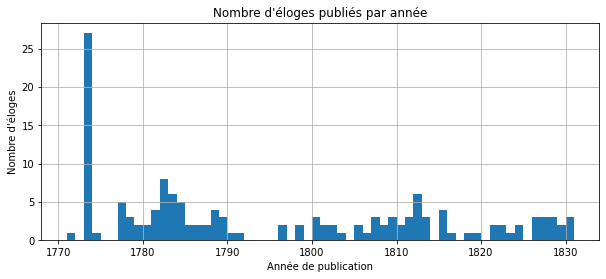

In [10]:
nbins = int(df['Annee'].max() - df['Annee'].min())
df.hist('Annee', bins = nbins, figsize = (10,4))
plt.title("Nombre d'éloges publiés par année")
plt.xlabel('Année de publication')
plt.ylabel("Nombre d'éloges")

In [11]:
df_help = df.groupby(['Annee'])['Savant'].count().reset_index().rename(columns = {'Savant' : 'count'})

df_pre = df_help[df_help['Annee']<=1793]
df_post = df_help[df_help['Annee']>1793]

In [12]:
#ttest indicating if the means are different
from scipy.stats import ttest_ind

ttest_ind(df_pre['count'].array, df_post['count'].array)

Ttest_indResult(statistic=1.8983552773467354, pvalue=0.06407384093561037)

In [13]:
#Years were there are no eulogies written but to include them in the visualizations

years_not = [i for i in range(df['Annee'].min(), df['Annee'].max()+1)]
years_not = [i for i in years_not if i not in df['Annee'].values]

## c. Length of the eulogies

In [14]:
#Removing the side information in the eulogies
side_info(df)

#Replacing the spelling of words
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('enfans', 'enfants').replace('instrumens', 'instruments')
                               .replace('talens', 'talents').replace('différens', 'différents').replace(
                               'monumens', 'monuments').replace('évènemens', 'évènements').replace('savans',
                                                                                                  'savants').
                               replace('documens', 'documents').replace('long-temps', 'longtemps'))

#Replacing encryption errors
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('†;', ';').replace('u?', 'ù').replace('¿', 'À')
                               .replace('∆', 'É').replace('∞', '°').replace('…', 'É').replace('¸','ü')
                               .replace('†:', ';').replace('†', ';'))

In [15]:
df['Weird'] = df['Eloge'].apply(lambda x : '  '.join(char for char in x if not char.isalnum()).split())

In [16]:
#Weird characters to check there are no encryption errors
df['Weird'].explode().value_counts()

,    51807
'    26205
’    22547
.    20809
;    8993 
-    4630 
:    2321 
?    459  
!    195  
(    189  
)    186  
"    117  
´    55   
*    53   
°    24   
\    18   
]    2    
¨    2    
‘    1    
«    1    
Name: Weird, dtype: int64

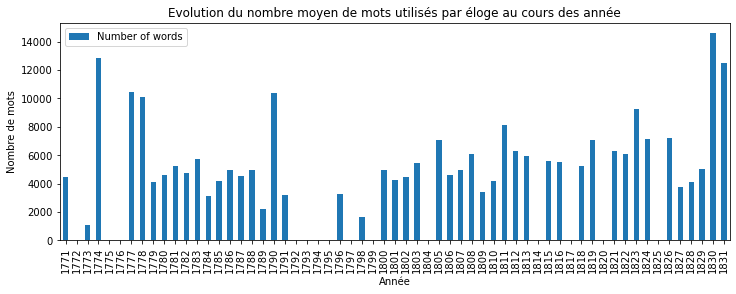

In [17]:
nbr_words_df = nbr_words(df, years_not, evol = True)

In [21]:
nbr_words_pre = nbr_words_df[nbr_words_df['Annee']<1793]
nbr_words_post = nbr_words_df[nbr_words_df['Annee']>=1793]

ttest_ind(nbr_words_pre['Number of words'].array, nbr_words_post['Number of words'].array)

Ttest_indResult(statistic=0.12100853109835964, pvalue=0.9040954542514035)

In [22]:
df['Length']=df['Eloge'].apply(lambda x : len(x.split()))

## d. Average word length

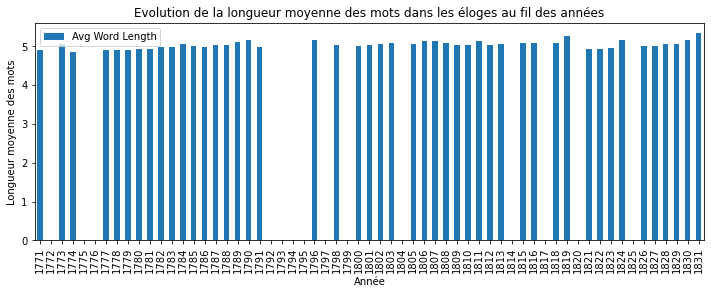

In [25]:
avg_words = avg_word_length(df, years_not, evol = True)

In [26]:
avg_words_pre = avg_words[avg_words['Annee']<=1793]
avg_words_post = avg_words[avg_words['Annee']>1793]

ttest_ind(avg_words_pre['Avg Word Length'].array, avg_words_post['Avg Word Length'].array)

Ttest_indResult(statistic=0.0425245162059346, pvalue=0.9662241561980204)

## e. Average sentence length

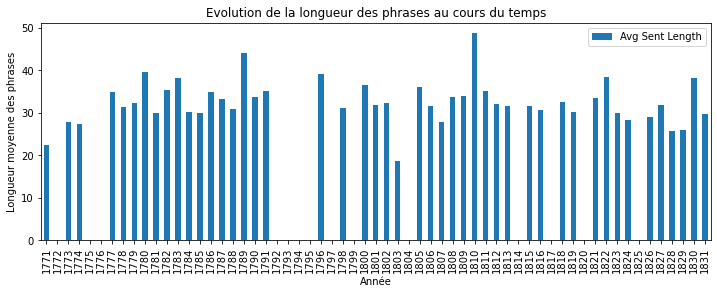

In [27]:
avg_sentence_df = avg_sentence(df,years_not, evol = True)

In [28]:
avg_sentence_pre = avg_sentence_df[avg_sentence_df['Annee']<1793]
avg_sentence_post = avg_sentence_df[avg_sentence_df['Annee']>=1793]

ttest_ind(avg_sentence_pre['Avg Sent Length'].array, avg_sentence_post['Avg Sent Length'].array)

Ttest_indResult(statistic=0.7451859670445371, pvalue=0.45911764467968497)

## f. Use of first person

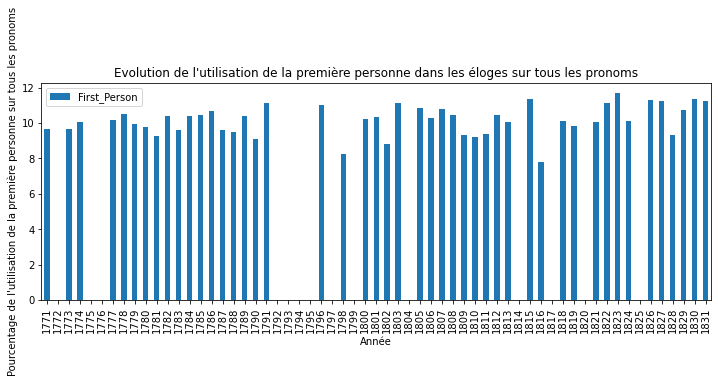

In [29]:
fst_person = first_person(df, years_not)

In [30]:
fst_person_pre = fst_person[fst_person['Annee']<1793]
fst_person_post = fst_person[fst_person['Annee']>=1793]

ttest_ind(fst_person_pre['First_Person'].array, fst_person_post['First_Person'].array)

Ttest_indResult(statistic=0.477815406462262, pvalue=0.6345471654824832)

## g. Use of imperative and conditionnal

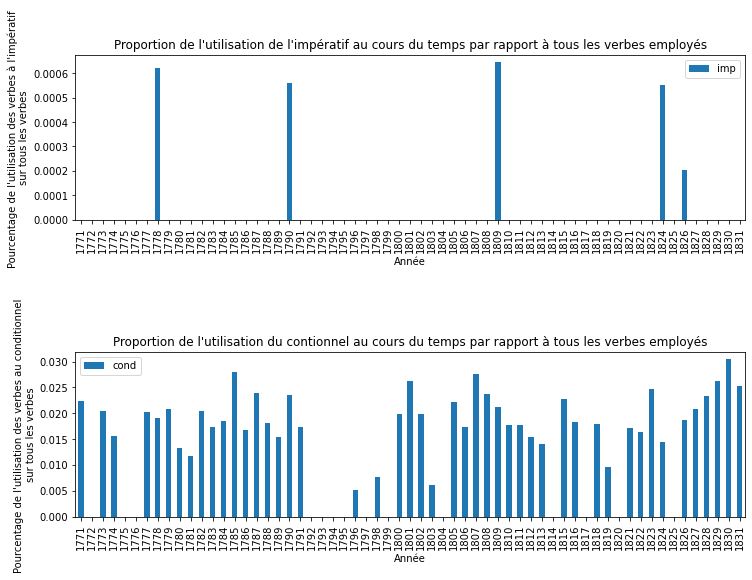

In [31]:
pci = cond_imperative(df, years_not)

## Dividing the eulogies by sentences

In [18]:
#Replacing M. by M for separation purposes
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('M.', 'M'))

sent = df.copy()

#Setting the separation character for sentences as '.'
sent['Eloge'] = sent['Eloge'].str.replace('!', '.')
sent['Eloge'] = sent['Eloge'].str.replace('?', '.')

#Dividing the sentences by '.'
sent['Eloge'] = sent['Eloge'].str.split('.')

# convert list of pd.Series then stack it
sent = (sent
 .set_index(['Savant','Auteur','Annee'])['Eloge']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_3', axis=1)
 .rename(columns={0:'Eloge'}))

#Removing sentences shorter than 10 characters and empty sentences
sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

sent.shape

(17784, 4)

## h. Use of adverbs

In [33]:
#Loading the adverbs dataset
df_ass = pd.read_csv('./../../Data/Results/ADV_BIG.csv')


#Dataframe with additionnal column containing solely the adverbs
adv = keep_adv(sent, 'Eloge')

#Adding columns that contains adverb that are in two different categoris
df_ass['Temp_Ass'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Temp_Exp'] = df_ass.apply(lambda row : 1 if ((row['Expérience']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Ass_Exp'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                 (row['Expérience']!='default value')) else 0,axis=1)


df_ass.head()

Adverb  Number      Categorie    Assertivité    Temporalité  \
0  -ci         74      default value  default value  default value   
1  -ci ne      5       default value  default value  default value   
2  absolument  54      affirmation    certain        default value   
3  ailleurs    91      lieu           default value  default value   
4  ainsi       564     logique        default value  default value   

      Expérience    Description  Temp_Ass  Temp_Exp  Ass_Exp  
0  default value  default value  0         0         0        
1  default value  default value  0         0         0        
2  default value  default value  0         0         0        
3  default value  default value  0         0         0        
4  default value  default value  0         0         0

In [34]:
df_ass[df_ass['Expérience']!='default value'].shape

(70, 10)

In [35]:
#Making lists containing all the adverbs in each category

ls_ass = df_ass[(df_ass['Assertivité']!='default value') & (df_ass['Temp_Ass']==0) &
                                                         (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp = df_ass[(df_ass['Temporalité']!='default value') & (df_ass['Temp_Ass']==0)
                & (df_ass['Temp_Exp']==0)]['Adverb'].tolist()
ls_exp = df_ass[(df_ass['Expérience']!='default value') & (df_ass['Temp_Exp']==0)
               & (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp_exp = df_ass[df_ass['Temp_Exp']==1]['Adverb'].tolist()
ls_ass_exp = df_ass[df_ass['Ass_Exp']==1]['Adverb'].tolist()
ls_temp_ass = df_ass[df_ass['Temp_Ass']==1]['Adverb'].tolist()
ls_desc = df_ass[df_ass['Description']=='description']['Adverb'].tolist()

In [36]:
#Creating a dataframe with one column for each category of adverb that list the adverbs of this category present in
#the sentence
plot_adv = adv.copy()
plot_adv = plot_adv[['Savant', 'Auteur', 'Annee', 'Eloge', 'adverbs']]
plot_adv['Assertivité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass]))
plot_adv['Temporalité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp]))
plot_adv['Expérience'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_exp]))
plot_adv['Temp_Ass'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_ass]))
plot_adv['Temp_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_exp]))
plot_adv['Ass_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass_exp]))
plot_adv['Description'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_desc]))
plot_adv['Else'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if (elem not in ls_ass
                                                                                   and elem not in ls_temp
                                                                                   and elem not in ls_exp
                                                                                   and elem not in ls_ass
                                                                                   and elem not in ls_temp_ass
                                                                                   and elem not in ls_ass_exp
                                                                                   and elem not in ls_temp_exp
                                                                                   and elem not in ls_desc)]))

<AxesSubplot:title={'center':"Evolution de l'utilisation des sortes d'adverbes au cours du temps"}, xlabel='Année'>

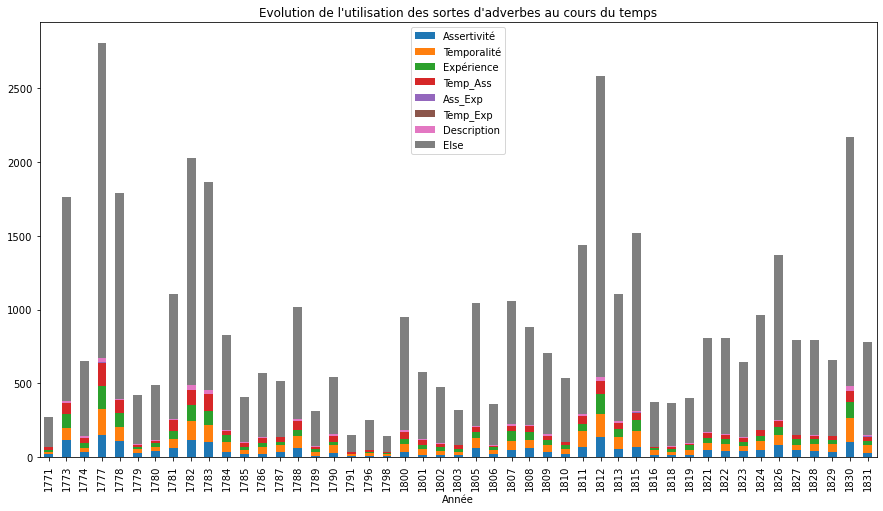

In [37]:
plot_adv_1 = plot_adv.groupby(['Annee']).agg({'Assertivité' : 'sum', 'Temporalité' : 'sum', 'Expérience' :
                                           'sum', 'Temp_Ass' : 'sum', 'Ass_Exp' : 'sum', 'Temp_Exp' : 'sum',
                                           'Description' : 'sum', 'Else' : 'sum'})

plot_adv_1.plot.bar(stacked = True, figsize = (15,8), xlabel='Année',
                    title="Evolution de l'utilisation des sortes d'adverbes au cours du temps")

In [38]:
plot_adv['Catégorie'] = plot_adv['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()
                                                             ['Categorie'][0]  
                                                             if elem in df_ass.Adverb.tolist() else 'Not Frequent'
                                                             for elem in x])


new_df = (
    plot_adv.explode('Catégorie')  # Explode List into Rows
        .groupby(['Annee','Catégorie']).size()  # Calculate Group Sizes
        .unstack(fill_value=0)  # Convert Category values to column names 
        .reset_index().rename_axis(columns=None)  # Cleanup
)

new_df.set_index('Annee', inplace = True)

<AxesSubplot:title={'center':"Evolution de l'utilisation des sortes d'adverbe au cours du temps"}, xlabel='Année'>

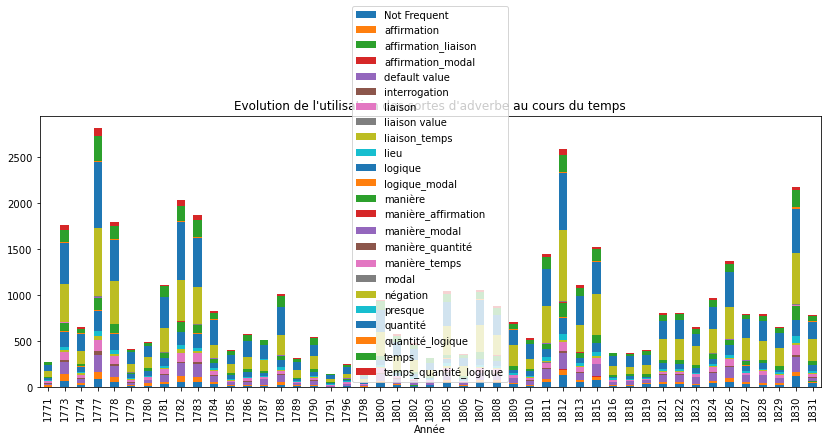

In [39]:
new_df.plot.bar( stacked=True, figsize = (14,5), title = 
                "Evolution de l'utilisation des sortes d'adverbe au cours du temps",
                xlabel='Année')

<AxesSubplot:title={'center':"Evolution de l'utilisation des sortes d'adverbe au cours du temps pour la première partie"}, xlabel='Année'>

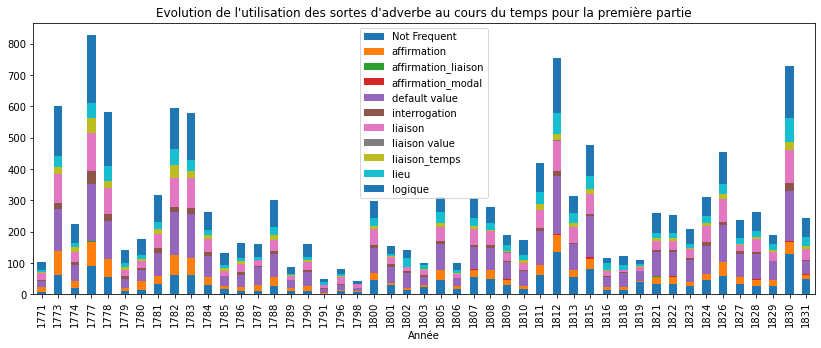

In [40]:
#Separating previous graph in two for better visualization
new_df.iloc[:,:11].plot.bar( stacked=True, figsize = (14,5), title = 
                "Evolution de l'utilisation des sortes d'adverbe au cours du temps pour la première partie", 
                            xlabel='Année')

<AxesSubplot:title={'center':"Evolution de l'utilisation des sortes d'adverbe au cours du temps pour la deuxième partie"}, xlabel='Année'>

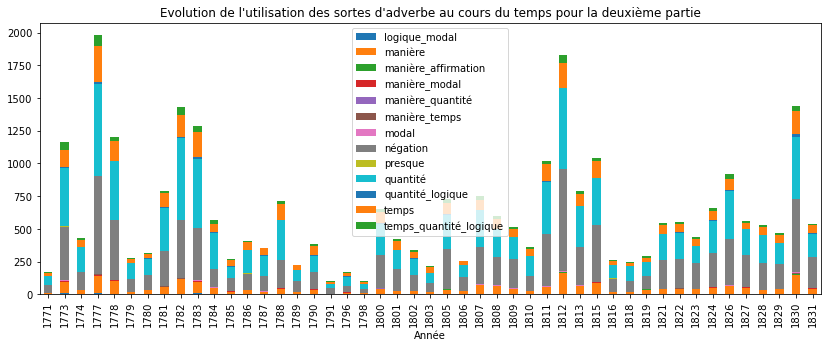

In [41]:
new_df.iloc[:,11:].plot.bar( stacked=True, figsize = (14,5), title = 
                "Evolution de l'utilisation des sortes d'adverbe au cours du temps pour la deuxième partie", 
                            xlabel='Année')

<AxesSubplot:title={'center':"Evolution de l'utilisation des catégories d'adverbes normés par le nombre d'adverbes utilisés chaque année"}, xlabel='Année'>

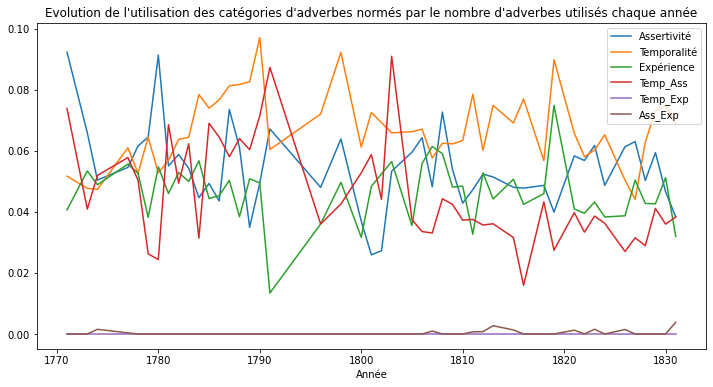

In [42]:
plot_adv_1['All'] = plot_adv_1.sum(axis=1)
plot_adv_1['Assertivité'] = plot_adv_1.apply(lambda row : row['Assertivité']/row['All'],axis=1)
plot_adv_1['Temporalité'] = plot_adv_1.apply(lambda row : row['Temporalité']/row['All'],axis=1)
plot_adv_1['Expérience'] = plot_adv_1.apply(lambda row : row['Expérience']/row['All'],axis=1)
plot_adv_1['Temp_Ass'] = plot_adv_1.apply(lambda row : row['Temp_Ass']/row['All'],axis=1)
plot_adv_1['Temp_Exp'] = plot_adv_1.apply(lambda row : row['Temp_Exp']/row['All'],axis=1)
plot_adv_1['Ass_Exp'] = plot_adv_1.apply(lambda row : row['Ass_Exp']/row['All'],axis=1)

plot_adv_1[['Assertivité', 'Temporalité', 'Expérience', 'Temp_Ass', 'Temp_Exp', 'Ass_Exp']].plot(kind='line',
                                                                                              figsize = (12,6),
            title="Evolution de l'utilisation des catégories d'adverbes normés par le nombre d'adverbes utilisés chaque année",
                                    xlabel='Année')

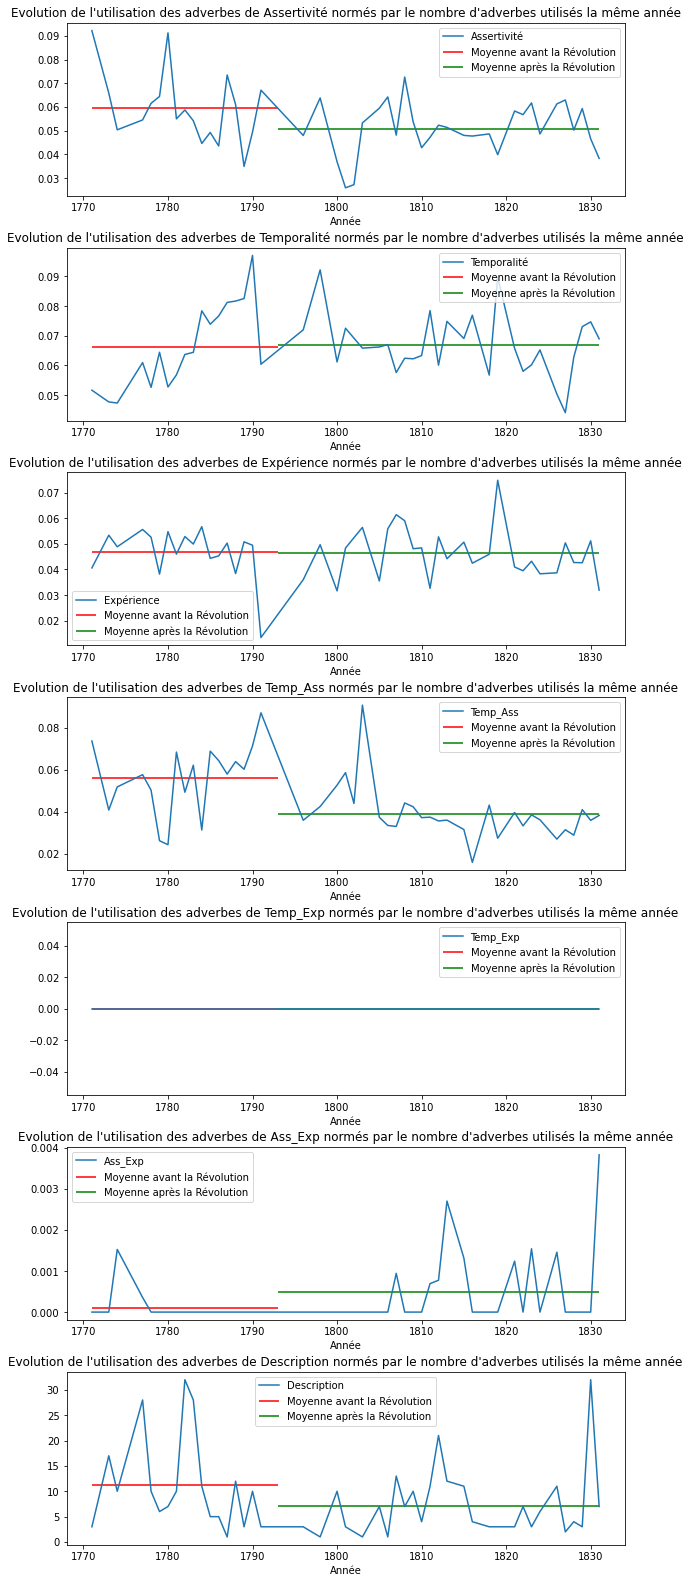

In [43]:
fig, ax = plt.subplots(nrows = 7, ncols=1, figsize = (10, 7*4))

ls = ['Assertivité', 'Temporalité', 'Expérience', 'Temp_Ass', 'Temp_Exp', 'Ass_Exp', 'Description']

for idx, cat in enumerate(ls):
    y1 = plot_adv_1[plot_adv_1.index<=1793][cat].mean()
    y2 = plot_adv_1[plot_adv_1.index>1793][cat].mean()
    plot_adv_1[[cat]].plot(kind='line', ax = ax[idx], xlabel='Année', title = "Evolution de l'utilisation des adverbes de " +
                          cat + " normés par le nombre d'adverbes utilisés la même année")
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Moyenne avant la Révolution')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Moyenne après la Révolution')
    
        
    ax[idx].legend()
plt.subplots_adjust(hspace = 0.3)

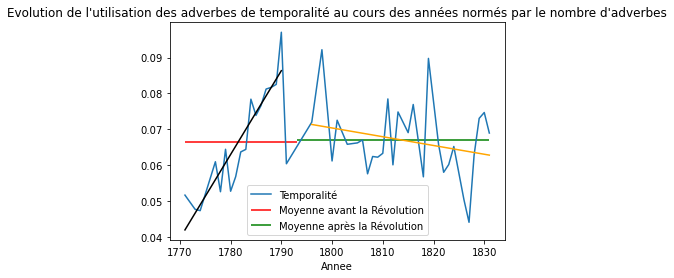

In [44]:
#Fitting a line for temporality

y1 = plot_adv_1[plot_adv_1.index<=1793]['Temporalité'].mean()
y2 = plot_adv_1[plot_adv_1.index>1793]['Temporalité'].mean()
plot_adv_1[['Temporalité']].plot(kind='line')
plt.hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Moyenne avant la Révolution')
plt.hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Moyenne après la Révolution')


a, b = np.polyfit(np.array(plot_adv_1['Temporalité'].loc[:1790].index),np.array(plot_adv_1['Temporalité'].
                                                                                loc[:1790].values),1)
plt.plot(np.array(plot_adv_1['Temporalité'].loc[:1790].index), a*np.array(plot_adv_1['Temporalité'].
                                                                          loc[:1790].index)+b, color = 'black')

a, b = np.polyfit(np.array(plot_adv_1['Temporalité'].loc[1795:].index),np.array(plot_adv_1['Temporalité'].
                                                                                loc[1795:].values),1)
plt.plot(np.array(plot_adv_1['Temporalité'].loc[1795:].index), a*np.array(plot_adv_1['Temporalité'].
                                                                          loc[1795:].index)+b, color = 'orange')

plt.title("Evolution de l'utilisation des adverbes de temporalité au cours des années normés par le nombre d'adverbes")
plt.legend()

## Assertivity

Studying the assertivity

In [45]:
ass = adv.copy()
ass = ass[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
ass['adverbs'] = ass['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_ass or elem in ls_temp_ass
                                                                        or elem in ls_ass_exp)])

ass['Catégorie'] = ass['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Assertivité'][0]
                                                   for elem in x])

<AxesSubplot:title={'center':"Evolution des sortes d'assertivité dans les éloges"}, xlabel='Année'>

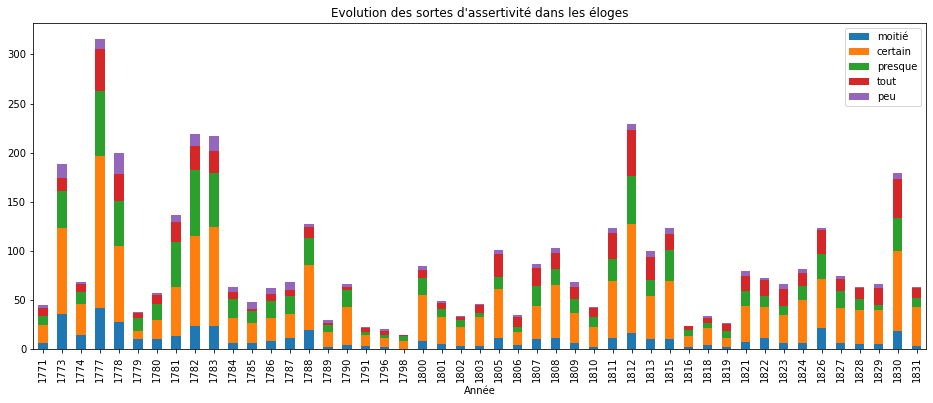

In [46]:
ls_cat = ass['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

for cat in ls_cat :
    ass[cat] = ass['Catégorie'].apply(lambda x : x.count(cat))
    
ass_plot = ass.groupby(['Annee'])[ls_cat].sum()

ass_plot.plot(kind='bar', stacked=True, figsize = (16,6), title = "Evolution des sortes d'assertivité dans les éloges",
             xlabel='Année')



Text(0.5, 0, 'Année')

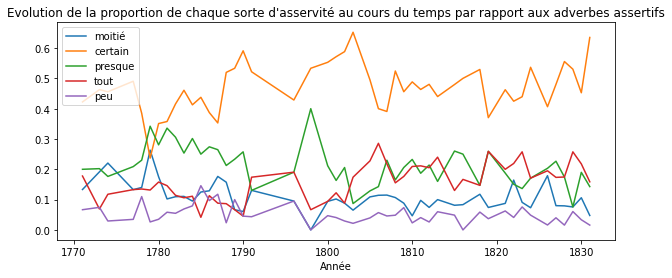

In [47]:
ass_plot['all'] = ass_plot.sum(axis=1)

for cat in ls_cat:
    ass_plot[cat] = ass_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    ass_plot[cat].plot(kind='line', figsize = (10,4), label=cat)
    
plt.legend()
plt.title("Evolution de la proportion de chaque sorte d'asservité au cours du temps par rapport aux adverbes assertifs")
plt.xlabel("Année")

Moyenne pre-rev : 0.14001252671119294 moitié
Moyenne post-rev : 0.09091019332451528 moitié
Ttest_indResult(statistic=2.267233386758836, pvalue=0.02681649380053331)
Moyenne pre-rev : 0.43300099767772393 certain
Moyenne post-rev : 0.4919730728615358 certain
Ttest_indResult(statistic=-1.6224081077585577, pvalue=0.10971020747432256)
Moyenne pre-rev : 0.24776965408358054 presque
Moyenne post-rev : 0.18962401862320333 presque
Ttest_indResult(statistic=2.0727106742131123, pvalue=0.0422961696903679)
Moyenne pre-rev : 0.1119252784404639 tout
Moyenne post-rev : 0.18597288827245387 tout
Ttest_indResult(statistic=-2.966430297638684, pvalue=0.004252838881903156)
Moyenne pre-rev : 0.06729154308703861 peu
Moyenne post-rev : 0.04151982691829184 peu
Ttest_indResult(statistic=1.8130699223553286, pvalue=0.07458528161046843)


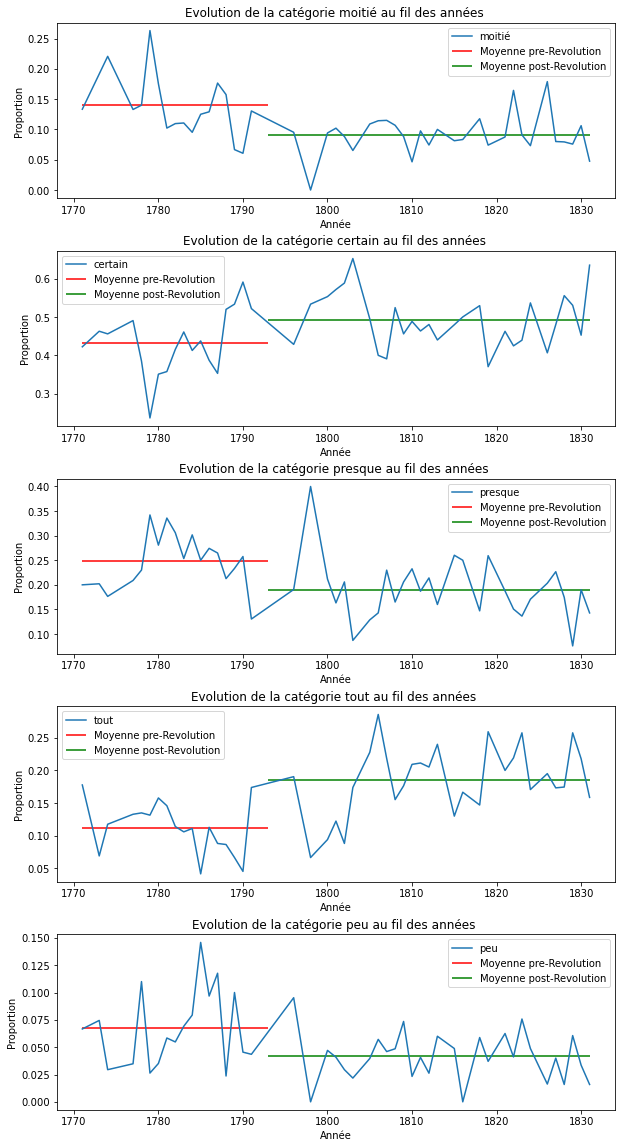

In [48]:
fig, ax = plt.subplots(nrows = ls_cat.size, ncols=1, figsize = (10, ls_cat.size*4))

for idx, cat in enumerate(ls_cat):
    y1 = ass_plot[ass_plot.index<=1793][cat].mean()
    y2 = ass_plot[ass_plot.index>1793][cat].mean()
    print('Moyenne pre-rev : ' + str(y1) + ' ' + cat)
    print('Moyenne post-rev : ' + str(y2) + ' ' + cat)
    ass_plot[[cat]].plot(kind='line', ax = ax[idx])
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Moyenne pre-Revolution')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Moyenne post-Revolution')      
    ax[idx].legend()
    ax[idx].set_title('Evolution de la catégorie ' + cat + ' au fil des années ')
    ax[idx].set_xlabel('Année')
    ax[idx].set_ylabel('Proportion')
    print(ttest_ind(ass_plot.loc[1771:1794][cat].array, ass_plot.loc[1771:][cat].array))
plt.subplots_adjust(hspace = 0.3)

## Temporality

In [49]:
temp = adv.copy()
temp = temp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
temp['adverbs'] = temp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_temp or elem in ls_temp_ass
                                                                        or elem in ls_temp_exp)])

temp['Catégorie'] = temp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Temporalité'][0]
                                                   for elem in x])

ls_cat = temp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['peu', 'suite', 'presque', 'maintenant', 'eternel', 'tot', 'passe',
       'tard', 'fréquence'], dtype=object)

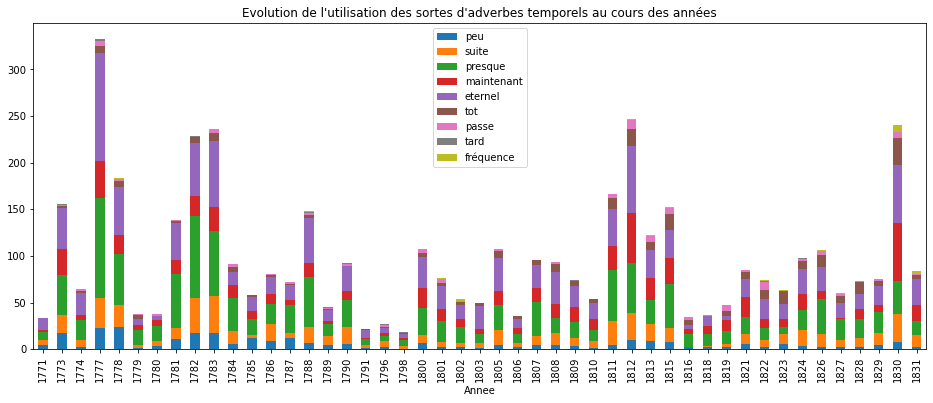

In [50]:
for cat in ls_cat :
    temp[cat] = temp['Catégorie'].apply(lambda x : x.count(cat))
    
temp_plot = temp.groupby(['Annee'])[ls_cat].sum()

temp_plot.plot(kind='bar', stacked=True, figsize = (16,6))
plt.title("Evolution de l'utilisation des sortes d'adverbes temporels au cours des années")

temp_plot['all'] = temp_plot.sum(axis=1)

Text(0.5, 1.0, "Evolution de la proportion de chaque sorte d'adverbes temporels au cours du temps par rapport aux adverbes temporels")

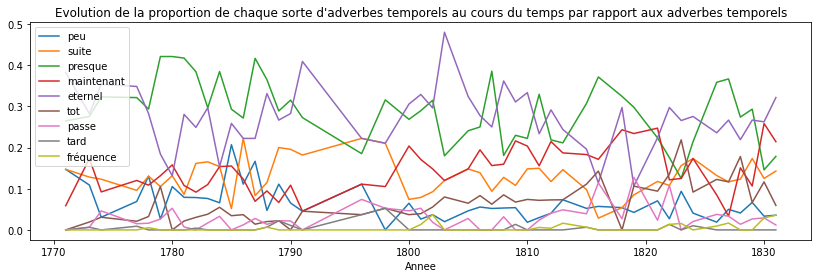

In [51]:
for cat in ls_cat:
    temp_plot[cat] = temp_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    temp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    
plt.legend()
plt.title("Evolution de la proportion de chaque sorte d'adverbes temporels au cours du temps par rapport aux adverbes temporels")

Moyenne pre-rev : 0.09286580278322039 peu
Moyenne post-rev : 0.04711972603014966 peu
Ttest_indResult(statistic=2.3681829560524994, pvalue=0.020956703055260154)
Moyenne pre-rev : 0.13768511953610707 suite
Moyenne post-rev : 0.12451663212847473 suite
Ttest_indResult(statistic=0.6699498036838581, pvalue=0.5053380563396312)
Moyenne pre-rev : 0.33478740914216565 presque
Moyenne post-rev : 0.25787112150484803 presque
Ttest_indResult(statistic=2.3811841896076555, pvalue=0.020291710999842793)
Moyenne pre-rev : 0.1094230599864749 maintenant
Moyenne post-rev : 0.16696384485218235 maintenant
Ttest_indResult(statistic=-2.5433750385048937, pvalue=0.013445775952622762)
Moyenne pre-rev : 0.27430275228879686 eternel
Moyenne post-rev : 0.2696025727305124 eternel
Ttest_indResult(statistic=0.1440937352245239, pvalue=0.8858863999822308)
Moyenne pre-rev : 0.02930442581274714 tot
Moyenne post-rev : 0.08680933927357648 tot
Ttest_indResult(statistic=-3.0299304182663205, pvalue=0.003545177612395588)
Moyenne pr

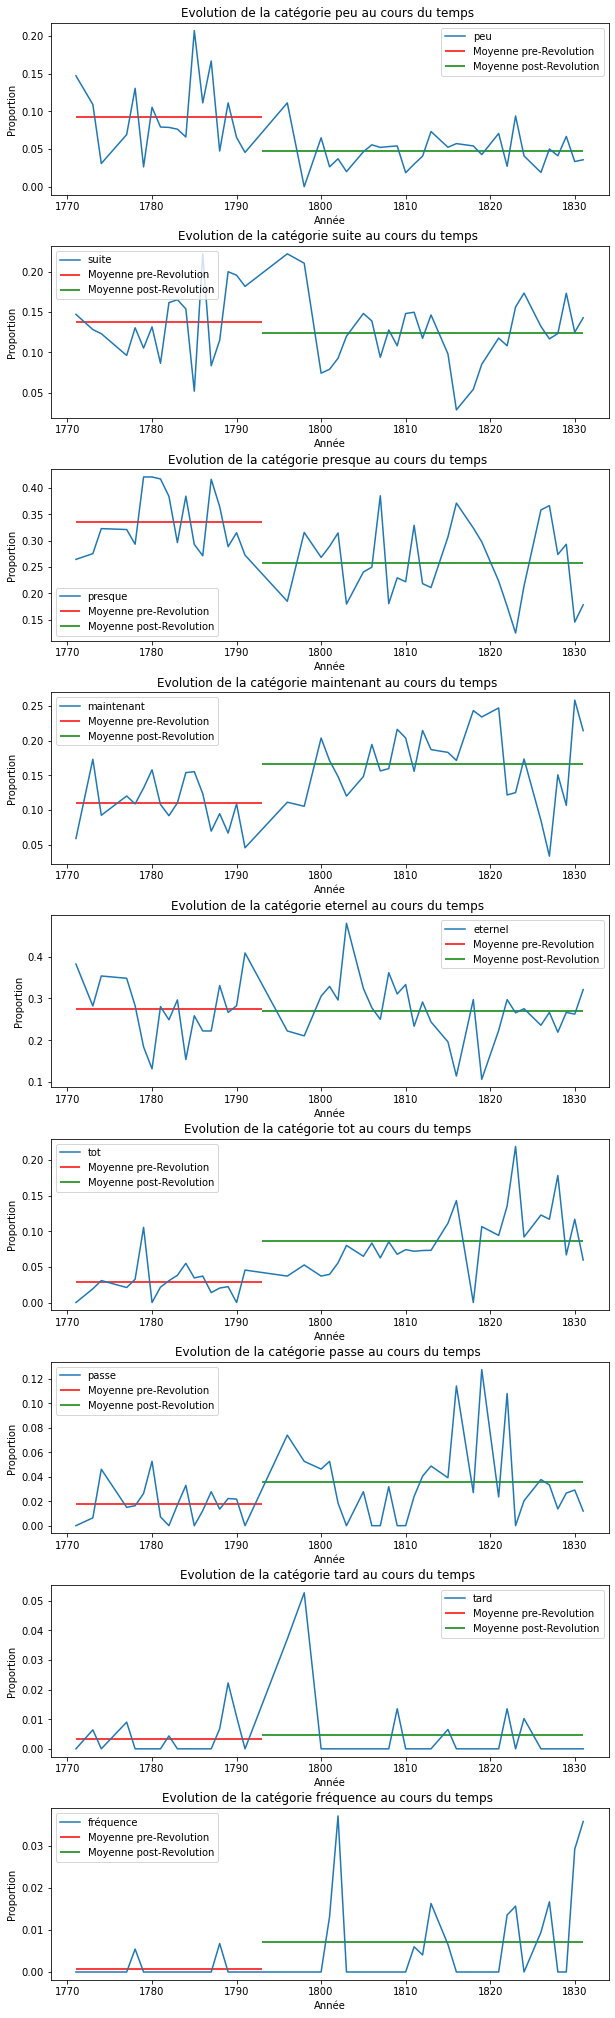

In [52]:
fig, ax = plt.subplots(nrows = ls_cat.size, ncols=1, figsize = (10, ls_cat.size*4))

for idx, cat in enumerate(ls_cat):
    y1 = temp_plot[temp_plot.index<=1793][cat].mean()
    y2 = temp_plot[temp_plot.index>1793][cat].mean()
    temp_plot[[cat]].plot(kind='line', ax = ax[idx])
    print('Moyenne pre-rev : ' + str(y1) + ' ' + cat)
    print('Moyenne post-rev : ' + str(y2) + ' ' + cat)
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-', label='Moyenne pre-Revolution')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-', label='Moyenne post-Revolution')
    ax[idx].legend()
    ax[idx].set_title('Evolution de la catégorie ' + cat + ' au cours du temps ')
    ax[idx].set_xlabel('Année')
    ax[idx].set_ylabel('Proportion')
    print(ttest_ind(temp_plot.loc[1771:1794][cat].array, temp_plot.loc[1771:][cat].array))

        
plt.subplots_adjust(hspace = 0.3)

## Experience

In [53]:
exp = adv.copy()
exp = exp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
exp['adverbs'] = exp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_exp or elem in ls_temp_exp
                                                                        or elem in ls_ass_exp)])

exp['Catégorie'] = exp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Expérience'][0]
                                                   for elem in x])

ls_cat = exp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['moins', 'plus'], dtype=object)

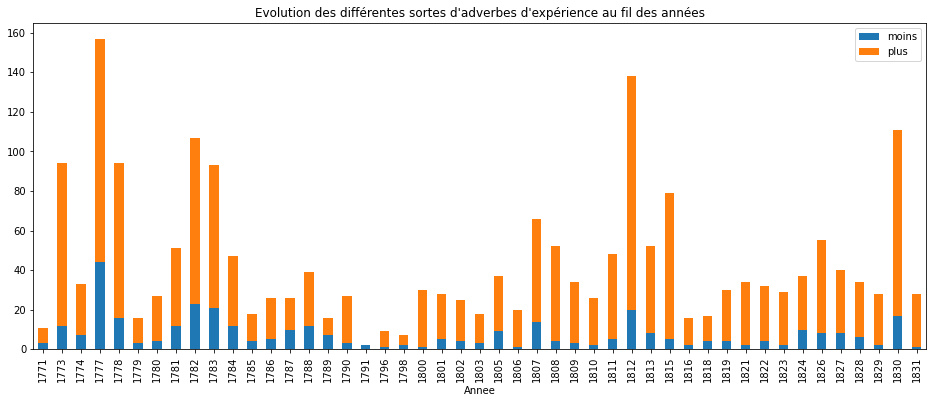

In [54]:
for cat in ls_cat :
    exp[cat] = exp['Catégorie'].apply(lambda x : x.count(cat))
    
exp_plot = exp.groupby(['Annee'])[ls_cat].sum()

exp_plot.plot(kind='bar', stacked=True, figsize = (16,6))
plt.title("Evolution des différentes sortes d'adverbes d'expérience au fil des années")

exp_plot['all'] = exp_plot.sum(axis=1)

Moyenne pre-rev : 0.2769691920925065 moins
Moyenne post-rev : 0.13613731505517065 moins
Ttest_indResult(statistic=1.910310330343636, pvalue=0.06064727478781358)
Moyenne pre-rev : 0.7230308079074936 plus
Moyenne post-rev : 0.8638626849448294 plus
Ttest_indResult(statistic=-1.9103103303436284, pvalue=0.06064727478781458)


Text(0, 0.5, "Proportion d'adverbes de chaque catégorie d'expérience normée \npar le nombre d'adverbes dans cette catégorie")

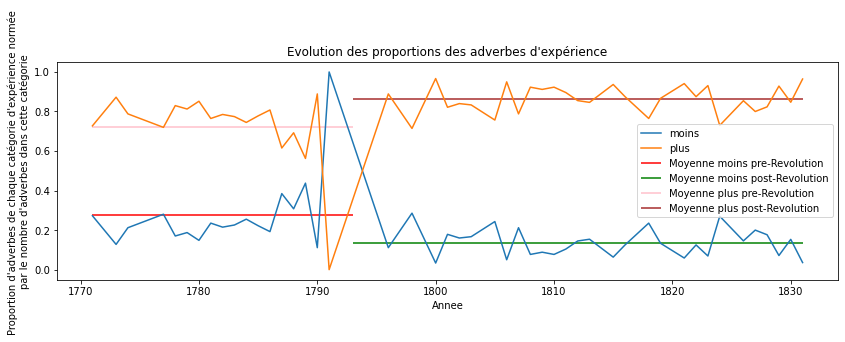

In [55]:
for cat in ls_cat:
    exp_plot[cat] = exp_plot.apply(lambda row : row[cat]/row['all'], axis=1)

ls=[('r', 'g'), ('pink', 'brown')]
    
for idx, cat in enumerate(ls_cat):
    y1 = exp_plot[exp_plot.index<=1793][cat].mean()
    y2 = exp_plot[exp_plot.index>1793][cat].mean()
    print('Moyenne pre-rev : ' + str(y1) + ' ' + cat)
    print('Moyenne post-rev : ' + str(y2) + ' ' + cat)
    plt.hlines(y=y1, xmin = 1771, xmax = 1793, colors = ls[idx][0], label='Moyenne '+cat+' pre-Revolution')
    plt.hlines(y=y2, xmin = 1793, xmax = 1831, colors = ls[idx][1], label='Moyenne '+cat+' post-Revolution')
    exp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    print(ttest_ind(exp_plot.loc[1771:1794][cat].array, exp_plot.loc[1771:][cat].array))

    
    
plt.legend()
plt.title("Evolution des proportions des adverbes d'expérience")
plt.ylabel("Proportion d'adverbes de chaque catégorie d'expérience normée \npar le nombre d'adverbes dans cette catégorie")

In [57]:
#Creating dataframe for obtaining most representative sentences for each adverb
df_h = keep_adv(df, 'Eloge')

In [58]:
#Most-representative sentences for each adverb
_,_=get_rep_adv(df_h, adv, df_ass, adv='adverbs')

P̲r̲e̲-̲R̲e̲v̲o̲l̲u̲t̲i̲o̲n̲ ̲:̲ 
Il avait, depuis l’âge de quarante ans environ, l’habitude de prendre tous les jours du vin de quinquina : il y renonça peu de temps avant sa mort ; et ce changement fut suivi d’un dépérissement prompt et rapide
Cependant, son goût pour les sciences était toujours le même ; et jusqu’à vingt-cinq ans ou environ, il y consacra tous les moments de relâche que ses douleurs lui laissaient
Dès ce moment, sa maladie changea de caractère ; une léthargie de trois jours succéda au seul accès de délire bien caractérisé qu'il ait éprouvé ; après ce temps, un réveil de quelques minutes, pendant lequel il parut avoir toute sa raison, fut suivi d’une nouvelle léthargie qui dura quatre jours ; ni les remèdes, ni les excitatifs ne pouvaient le tirer de cet état ; à peine était-il possible de lui faire avaler quelques gouttes d’eau ; ses membres étaient mous et flexibles ; les mouvements des artères étaient insensibles ; un battement de cour qu’on avait peine à saisir, 

In [59]:
_,_=get_rep_adv(df_h, adv, df_ass, adv='adverbs', adverb='toujours', categorie='Temporalité')

P̲r̲e̲-̲R̲e̲v̲o̲l̲u̲t̲i̲o̲n̲ ̲:̲ 
M Fontaine eut avec plusieurs géomêtres de ces disputes toujours surprenantes pour ceux qui, ne connaissant de la géométrie que les routes battues, ignorent que, dans la science même de la certitude le génie peut s’égarer quelquefois dans les routes nouvelles qu’il a osées se frayer
Je me suis arrêté longtemps sur Charles Perrault, en faisant l’éloge de son frère ; mais ils s’étaient toujours tendrement aimés, et c’est un hommage à la mémoire de notre académicien, que d’avoir consacré quelques lignes à défendre celle d’un frère qui lui fut si cher
Dans tous les problèmes sur les nombres qui se proposaient alors, on voyait toujours une solution de Frenicle à côté de celles de Descartes et de Fermat, qui avouèrent souvent que celle de Frenicle était plus élégante
P̲o̲s̲t̲-̲R̲e̲v̲o̲l̲u̲t̲i̲o̲n̲ ̲:̲ 
Son zèle eut à combattre et la briéveté du temps pendant lequel il put se préparer à un travail qu’il n’avoit pas prévu, et la grandeur du vaisseau dans leque

In [60]:
ls_cat_ass = df_ass['Assertivité'].unique().tolist()
ls_cat_temp = df_ass['Temporalité'].unique().tolist()
ls_cat_exp = df_ass['Expérience'].unique().tolist()

In [61]:
ls_cat_ass.pop(ls_cat_ass.index('default value'))
ls_cat_temp.pop(ls_cat_temp.index('default value'))
ls_cat_exp.pop(ls_cat_exp.index('default value'))

'default value'

In [62]:
ls_cat_ass

['certain', 'presque', 'tout', 'peu', 'moitié']

## h. Use of past tenses

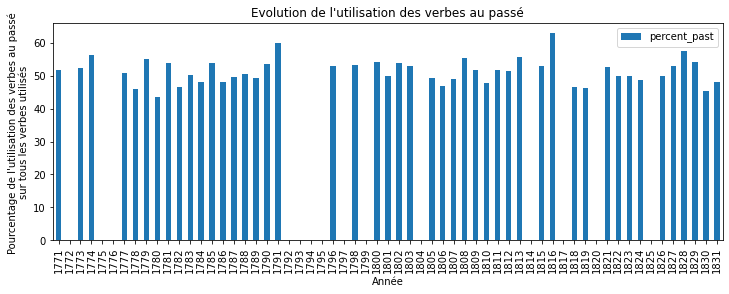

In [66]:
past_tense_df = past_tense(df, years_not)

In [67]:
past_tense_pre = past_tense_df[past_tense_df['Annee']<1793]
past_tense_post = past_tense_df[past_tense_df['Annee']>=1793]

ttest_ind(past_tense_pre['percent_past'].array, past_tense_post['percent_past'].array)

Ttest_indResult(statistic=0.5928739221007915, pvalue=0.5555313063395211)

Reject Null Hypothesis the means are statistically different

## i. Starts with a statement on the birth

Number of eulogies that start with a statement on the birth

In [68]:
naissance(df)

In [69]:
print('Number of eulogies that start with a statement on the birth : ' + str(df[df['naissance'] == False].shape[0]))

Number of eulogies that start with a statement on the birth : 49


In [70]:
print('Number of eulogies that start with a statement on the birth before the Revolution : ' + 
      str(df[(df['naissance'] == False)&(df['Annee']<1793)].shape[0]))

Number of eulogies that start with a statement on the birth before the Revolution : 15


In [71]:
print('Number of eulogies that start with a statement on the birth after the Revolution : ' + 
      str(df[(df['naissance'] == False)&(df['Annee']>=1793)].shape[0]))

Number of eulogies that start with a statement on the birth after the Revolution : 34


## j. Use of Proper Names


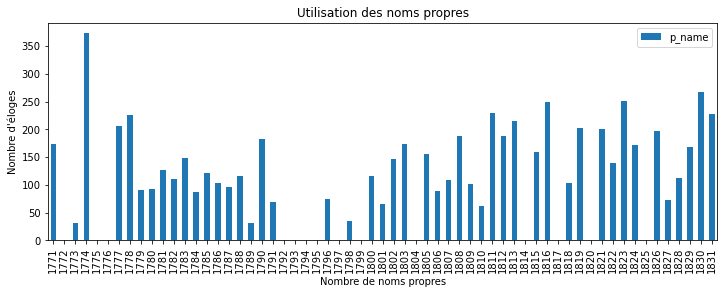

In [72]:
p_n = proper_name(df, years_not)

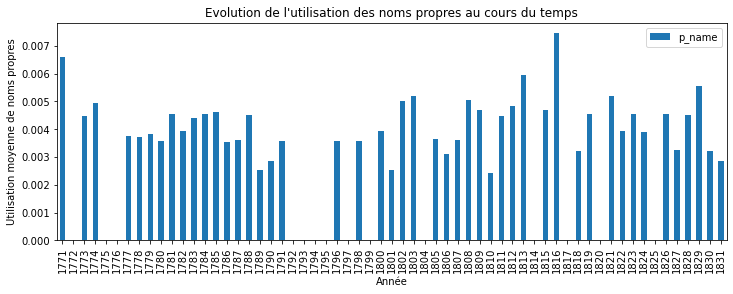

In [73]:
p_norm = proper_name(df, years_not, norm = True)

# 3. Second axis : Topic modeling

## Sentences to remove

In [19]:
sent[(sent['Eloge'].str.contains('Condorcet'))&(sent['Annee']<1796)]

Savant     Auteur  Annee                  Eloge
3173  Pascal  Condorcet  1778    (Page 133) Condorcet
3198  Pascal  Condorcet  1778   ) Condorcet          
3211  Pascal  Condorcet  1778   ) Condorcet          
3224  Pascal  Condorcet  1778    235) Condorcet      
3237  Pascal  Condorcet  1778   ) Condorcet          
3251  Pascal  Condorcet  1778    (P 290) Condorcet   
3260  Pascal  Condorcet  1778   ) Condorcet          
3270  Pascal  Condorcet  1778   ) Condorcet          
3277  Pascal  Condorcet  1778   ) Condorcet          
3361  Pascal  Condorcet  1778    309) Condorcet      
3377  Pascal  Condorcet  1778   ) Condorcet          
3386  Pascal  Condorcet  1778    325) Condorcet      
3404  Pascal  Condorcet  1778    331) Condorcet      
3417  Pascal  Condorcet  1778   ) Condorcet          
3422  Pascal  Condorcet  1778    391) Condorcet      
3430  Pascal  Condorcet  1778    462) Condorcet      
3440  Pascal  Condorcet  1778    491) Condorcet

In [20]:
sent = sent[(sent['Eloge'].str.contains('Condorcet')==False)|(sent['Annee']>1796)].reset_index()
#sent.drop('index')
sent.shape

(17767, 5)

In [21]:
sent.drop(columns = ['index'])

Savant     Auteur  Annee  \
0      Fontaine   Condorcet  1771    
1      Fontaine   Condorcet  1771    
2      Fontaine   Condorcet  1771    
3      Fontaine   Condorcet  1771    
4      Fontaine   Condorcet  1771    
...         ...         ...   ...    
17762  Desmarets  Cuvier     1815    
17763  Desmarets  Cuvier     1815    
17764  Desmarets  Cuvier     1815    
17765  Desmarets  Cuvier     1815    
17766  Desmarets  Cuvier     1815    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Eloge  
0      Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1       Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2       Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
3       Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donne

In [22]:
#Preprocessing the sentences
rmv_sw(sent, name_col = 'Eloge')
rmv_punkt(sent)
lemmatize(sent, 'no_sw_no_punkt', 'tags')
rmv_digit(sent)

In [23]:
#Only keeping nouns and verbs to avoid noise
nouns_verbs(sent, 'Eloge_lem', adj = True)

In [24]:
#Removing stop words and really short words that might still be here
sent['n_v'] = sent['n_v'].apply(lambda x : ' '.join([elem for elem in x.split() if (elem not in fr_stop and 
                                                                                    len(elem)>2)]))

In [25]:
#sent.reset_index(inplace = True)
sent.drop('index', axis = 1, inplace = True)
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 

## Embedding models

I tested different embedding models and chose to stay with the sentence transformer as it was the one working  the best

In [26]:
np.random.seed(123)

model_sent = SentenceTransformer('distiluse-base-multilingual-cased-v1')

#modelname = 'flaubert/flaubert_base_cased' 
#flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)

#camembert = CamembertModel.from_pretrained('camembert/camembert-base-wikipedia-4gb')

## Bertopic

In [27]:
#Loading Bertopic with embedding model chosen and nr_topics to auto so that topic with more than 0.9 similarity are
#merged
model = BERTopic(embedding_model = model_sent, min_topic_size=20,
                 nr_topics='auto',calculate_probabilities = True, n_gram_range = (1,2))

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [51]:
topics, probabilities = model.fit_transform(sent.n_v)


In [28]:
#Loading the model

#model.save('./../../Data/Results/bert_model')
model = BERTopic.load('./../../Data/Results/bert_model')

In [29]:
#Loading the topics attributed to sentences

#with open("./../../Data/Results/topics", "wb") as fp:   #Pickling
 #   pickle.dump(topics, fp)
 
with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
    topics = pickle.load(fp)


In [30]:
#Loading the probabilities attributed to sentences

#with open("./../../Data/Results/probabilities", "wb") as fp:   #Pickling
 #   pickle.dump(probabilities, fp)
    
    
with open("./../../Data/Results/probabilities", "rb") as fp:   # Unpickling
    probabilities = pickle.load(fp)

In [31]:
#Creating a dataframe to see most representative sentences for each topic

df_rep = pd.DataFrame({'Topic': topics, 'Document': sent.Eloge_lem, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})

#First topic
df_rep['Prob'] = df_rep.apply(lambda row : probabilities[row.name][row['Topic']], axis = 1)
df_rep['All_Probs'] = df_rep.apply(lambda row : probabilities[row.name], axis = 1)

#Second topic
df_rep['Scd_Topic'] = df_rep['All_Probs'].apply(lambda x : x.argsort()[-2])
df_rep['Scd_Prob'] = df_rep.apply(lambda row : probabilities[row.name][row['Scd_Topic']], axis=1)
df_rep['Fst_Topic'] = df_rep['All_Probs'].apply(lambda x : x.argsort()[-1])

#Third topic
df_rep['Third_Topic'] = df_rep['All_Probs'].apply(lambda x : x.argsort()[-3])
df_rep['Third_Prob'] = df_rep.apply(lambda row : probabilities[row.name][row['Third_Topic']], axis=1)

In [32]:
#Loading information about the topics

df_info = model.get_topic_info()
df_info

Topic  Count  \
0  -1      10027   
1   0      1363    
2   1      524     
3   2      469     
4   3      422     
5   4      414     
6   5      374     
7   6      366     
8   7      347     
9   8      336     
10  9      230     
11  10     212     
12  11     190     
14  12     173     
13  13     173     
15  14     142     
16  15     134     
17  16     125     
18  17     112     
19  18     110     
20  19     101     
21  20     97      
22  21     96      
23  22     91      
25  23     85      
24  24     85      
26  25     71      
27  26     68      
28  27     67      
29  28     65      
30  29     61      
31  30     61      
32  31     47      
33  32     43      
34  33     43      
35  34     42      
37  35     38      
36  36     38      
38  37     37      
39  38     36      
40  39     34      
41  40     34      
42  41     32      
43  42     30      
44  43     29      
45  44     27      
46  45     24      
47  46     21      
48  47     21      

                                                                      Name  
0   -1_faire_homme_pouvoir_grand                                            
1   0_animal_euler_loi_équation                                             
2   1_fil_père_fils_fil fil                                                 
3   2_science_progrès_savant_homme                                          
4   3_médecin_maladie_malade_médeciner                                      
5   4_card_card card_publier_année                                          
6   5_jardin_botanique_planter_botaniste                                    
7   6_air_acide_eau_sel                                                     
8   7_pierre_minéral_montagne_rocher                                        
9   8_astronome_astronomie_observation_mouvement                            
10  9_chimie_chimiste_chimiquer_substance                                   
11  10_philosophie_philosophe_poète_philosopher                             
12  11_prince_roi_royal_vouloir                                             
14  12_jeune_jeunesse_jeune homme_homme                                     
13  13_rayon_lumière_rayer raire_rayer                                      
15  14_génie_homme génie_homme_grand                                        
16  15_mémoire_souvenir_oublier_rappeler                                    
17  16_imprimer_écrire_manuscrit_édition                                    
18  17_naturel_nature_histoire naturel_histoire                             
19  18_artiste_art_talent_savant artiste                                    
20  19_géomètre_géométrie_méthode_problème                                  
21  20_théorie_général_expérience_théorie terre                             
22  21_religion_religieux_chrétien_dieu                                     
23  22_langue_latin_livre_traduction                                        
25  23_expérience_expérience faire_expérience direct_répéter expérience     
24  24_travail_carrière_temps_devoir                                        
26  25_anatomie_histoire_histoire naturel_naturel                           
27  26_ministre_ministère_gouvernement_ennemi                               
28  27_mathématique_mathématicien_calcul_étude mathématique                 
29  28_année_dernier année_dernier_année marquer                            
30  29_mois moi_mois_moi_dernier mois                                       
31  30_fluide_mouvement_corps_équilibre                                     
32  31_force_forces_force forces_force force                                
33  32_catholique_clergé_protester_religion                                 
34  33_horloge_horlogerie_penduler_perfection                               
35  34_marquis_colonel_maréchal_régiment                                    
37  35_impôt_payer_peuple_indirect                                          
36  36_matériau_matériau matériau_matériaux matériau_matériaux              


In [33]:
#Printing most representative sentences for one topic

_ = sent_rep(29, df_rep)

  Il passa quinze mois à Londres, vivant dans la retraite la plus absolue, et ne s'occupant que de la collection précieuse qu'il y avait portée


 M D’Alembert crut lui devoir l’hommage de sa reconnaissance, et, après l’avoir été trouver dans ses États de Westphalie, il le suivit à Berlin, où il passa plusieurs mois


 Il apprenait à s'en passer, et ce qu'il regrettait le plus, c'étaient six mois perdus dans l'inaction


 Les préparatifs durèrent plusieurs mois sans que personne violût le secret


 Le 5 de ce même mois, il s'éteignit sans douleur


  Ses accès, après avoir augmenté jusqu’à durer une semaine entière, commencèrent à diminuer au bout de quelques mois ; il avait chaque jour plusieurs heures d’intervalles


 Cette vogue dura vingt-deux mois, au bout desquels il se trouva assez riche pour ne songer qu’au repos


 et toute cette fondation était Pouvrage des quinze mois précédents que M de Rumford avait passés en Angleterre avec l'espoir de s'y fixer


 Un ulcère charbonneux v

In [34]:
df_hel = get_rep_aux_topic(df_rep, 31, perc=5, scd=False)

T̲h̲i̲r̲d̲ ̲t̲o̲p̲i̲c̲ ̲3̲8̲ ̲:
 Joseph était doué d'une force de corps supérieure à celle des hommes ordinaires


 Si les édifices qui en sont munis, ont encore quelques dangers à redouter, c’est qu’entre les efforts de l’homme, toujours si bornés, et les forces de la nature, il ne peut jamais s’établir qu’une lutte inégale


 Par malheur il apprit au bout de bien peu de temps que les effets des passions humaines ne se laissent pas calculer si aisément que ceux des forces de la nature


 mais dans la force de l'âge, et d'une dextérité sans égale


 dans la force de l'âge, et au moment où il entrevoyait enfin la possibilité


T̲h̲i̲r̲d̲ ̲t̲o̲p̲i̲c̲ ̲4̲2̲ ̲:
 Aussitôt l'on commença à entrevoir à quel point les différents airs devaient influer sur les phénomènes de la nature, et à juger qu'une physique et une chimie créées sans aucun égard à des agents si puissants et si universels, ne pouvaient être solides


 Il n’avait pas la force de résister à ses premiers mouvements, de taire ses p

## Hierarchical clustering

In [36]:
#Classifying the topic in upper categories
topic_medecine = [3]
topic_ciel = [8]
topic_vie = [1, 4, 12, 24, 28, 29, 31, 44, 47]
topic_biologie = [5, 17, 25]
topic_geologie = [7]
topic_chimie = [6, 9]
topic_politique = [11, 26, 34, 35, 39, 40]
topic_philosophie = [10]
topic_physique = [13, 30, 33, 38, 42]
topic_mathematiques = [19, 27]
topic_methode = [20, 23, 36, 45, 46]
topic_religion = [21, 32]
topic_memoire = [15, 16, 22]
topic_voyage = [43]
topic_perso = [2, 14, 18, 37, 41]

In [37]:
topic_dict = {'Médecine' : topic_medecine, 'Astronomie' : topic_ciel, 'Vie' : topic_vie, 'Biologie' : topic_biologie,
             'Géologie' : topic_geologie, 'Chimie' : topic_chimie, 'Politique' : topic_politique,
             'Philosophie' : topic_philosophie, 'Physique' : topic_physique, 
             'Mathématiques' : topic_mathematiques, 'Méthode' : topic_methode, 'Religion' : topic_religion,
             'Mémoire' : topic_memoire, 'Voyage' : topic_voyage, 'Figure-Type' : topic_perso}


In [38]:
#higher topics

topic_science = (topic_ciel + topic_chimie + topic_biologie + topic_philosophie + topic_physique
                + topic_mathematiques + topic_medecine + topic_geologie)
topic_personne = topic_vie + topic_perso
topic_posterite = topic_memoire 
topic_societe = topic_religion + topic_politique
topic_theorie = topic_methode

In [39]:
high_dict = {'Sciences' : topic_science, 'Personne' : topic_personne, 'Postérité' : topic_posterite,
            'Société' : topic_societe,'Méthode' : topic_theorie, 'Voyage' : topic_voyage}

In [40]:
#BERTmodel hierarachy

model.visualize_hierarchy()

In [41]:
#Plot the hierarchy made and saving it as html file

df_plot = df_info.copy()
df_plot['High_High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, high_dict)[1])
df_plot['High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, topic_dict)[1])
df_plot = df_plot[df_plot['High_Topic']!='outlier']
df_plot['Phrase'] = df_plot['Topic'].apply(lambda x : sent_rep(x, df_rep, print_=False).Eloge.tolist())
df_plot = df_plot.explode('Phrase')

fig = px.icicle(df_plot, path=[px.Constant("all"), 'High_High_Topic', 'High_Topic', 'Name', 'Phrase'],
               title = "Hiérarchie des topics")
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
fig.write_html('./../../Data/Results/hierarchy.html')

In [42]:
df_plot[df_plot['Topic']==41]

Topic  Count                                       Name High_High_Topic  \
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         
42  41     32     41_cardinal_cardinal luynes_luynes_vergne  Personne         

     High_Topic  \
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   
42  Figure-Type   

                                                                                                                                                                                                                                                                                          Phrase  
42   Le cardinal de Lorraine avait promis à l’hypocrite Granvelle d’introduire en France l’inquisition                                                                                                                                                                                            
42   Si cela est, c’est un malheur pour vous, et je dois chercher à vous détromper ; mais d’autres m’ont assuré que vous étiez digne de la place, et vous aurez ma voix  M le cardinal de Luynes termina une carrière paisible et vertueuse par une mort douce, le 22 janvier 1788                
42   Le cardinal de Tournon, le cardinal de Lorraine auraient été jaloux d’acquérir des droits sur sa reconnaissance : mais ils n’étaient pas dignes d’être les bienfaiteurs d’un homme vertueux ; et l’honneur de mettre enfin l’Hopital à sa véritable place était réservé à une âme plus pure  
42   Peu d’évêques ont mieux rempli que M le cardinal de Luynes, la double tâche d’instruire les hommes de leurs devoirs et de les soulager dans leurs malheurs                                                                                                                                   
42   Le cardinal de Richelieu n’avait vu, dans les gens de lettres, que des hommes utiles à sa gloire : Colbert, dirigé par Perrault, les traita comme des hommes utiles à l’humanité, dont la gloire honore leur pays et leur siècle                                                             
42   Le cardinal sentait que l’impétuosité de son caractère l’avait emporté trop loin ; et que trop faible pour braver ses ennemis, il fallait se donner du temps pour les tromper ou pour les corrompre                                                                                          
42   Le jeune Gilbert était trop fier pour subir une peine qu'il croyait injuste, et il alla demeurer dans un autre collège, celui du Cardinal-le-Moine                                                                                                                                           
42   Il avait pris, sous le cardinal de Fleury, l’habitude de la modération et de la modestie, sans rien perdre de ce ton gai et facile qu'il avait vu, dans sa première jeunesse, remplacer la dignité des ministres de Louis XIV                                                                
42   Un de ses amis s’était vu forcé de s’opposer au cardinal de Richelieu, alors tout-puissant, et qui savait également violer les formes, ou les faire servir à sa vengeance                                                                                                                    
42   Il s’agis

## Topics over time

Studying the evolution of topics over time

In [56]:
df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,

                       'Savant' : sent.Savant, 'Auteur' : sent.Auteur})

df_top['Words'] = df_top['Topic'].apply(lambda x : df_info[df_info['Topic']==x].reset_index()['Name'][0])
df_top['Words'] = df_top['Words'].apply(lambda x : ', '.join(x.split('_')[1:]))

In [57]:
#Normalize by number of sentences

topics_over_time_norm = df_top.groupby(['Annee', 'Topic', 'Words'])['Eloge'].count().reset_index()
topics_over_time_norm.rename(columns = {'Annee' : 'Timestamp', 'Eloge' : 'Frequency'}, inplace = True)

topics_over_time_norm.head()

Timestamp  Topic                                Words  Frequency
0  1771      -1      faire, homme, pouvoir, grand         73       
1  1771       0      animal, euler, loi, équation         17       
2  1771       1      fil, père, fils, fil fil             4        
3  1771       2      science, progrès, savant, homme      3        
4  1771       3      médecin, maladie, malade, médeciner  1

In [58]:
#Count the number of eulogies or sentences this year for the normalization

df_by_year = df.groupby('Annee')['Eloge'].count().reset_index()
sent_by_year = sent.groupby('Annee')['Eloge'].count().reset_index()

In [59]:
sent_topic_time = topics_over_time_norm.copy()

topics_over_time_norm = pd.merge(topics_over_time_norm, df_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')
topics_over_time_norm.head()

Timestamp  Topic                                Words  Frequency  Annee  \
0  1771      -1      faire, homme, pouvoir, grand         73         1771    
1  1771       0      animal, euler, loi, équation         17         1771    
2  1771       1      fil, père, fils, fil fil             4          1771    
3  1771       2      science, progrès, savant, homme      3          1771    
4  1771       3      médecin, maladie, malade, médeciner  1          1771    

   Eloge  
0  1      
1  1      
2  1      
3  1      
4  1

In [60]:
sent_topic_time = pd.merge(sent_topic_time, sent_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')

In [61]:
#This section is to addd the years where there are no eulogies to the plot

years = [i for i in range(1771, 1833)]

year_not = [i for i in years if i not in topics_over_time_norm.Timestamp.values]

In [62]:
df_topics = df_top.copy()
df_topics = df_topics[['Topic', 'Words']].drop_duplicates().reset_index()
df_topics.pop('index')
df_topics['Name'] = df_topics.apply(lambda row : str(row['Topic']) + '_' +
                                                           '_'.join(row['Words'].split(', ')), axis=1)


In [63]:
#Adding the years to both dataframes

for year in year_not:
    df_help = df_topics.copy()
    df_help['Timestamp'] = year
    df_help['Frequency'] = 0
    df_help['Eloge'] = 1
    topics_over_time_norm = topics_over_time_norm.append(df_help, ignore_index=True)
    sent_topic_time = sent_topic_time.append(df_help, ignore_index=True)



In [64]:
#Normalizing 

topics_over_time_norm['Frequency'] = topics_over_time_norm.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
topics_over_time_norm.pop('Eloge')
topics_over_time_norm.pop('Annee')

sent_topic_time['Frequency'] = sent_topic_time.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
sent_topic_time.pop('Eloge')
sent_topic_time.pop('Annee')

0       1771.0
1       1771.0
2       1771.0
3       1771.0
4       1771.0
         ...  
2090   NaN    
2091   NaN    
2092   NaN    
2093   NaN    
2094   NaN    
Name: Annee, Length: 2095, dtype: float64

In [65]:
topics_over_time_norm.sort_values(by='Timestamp', inplace = True)
topics_over_time_norm.reset_index(inplace=True)
topics_over_time_norm.pop('index')


sent_topic_time.sort_values(by='Timestamp', inplace = True)
sent_topic_time.reset_index(inplace=True)
sent_topic_time.pop('index')

0       0   
1       14  
2       13  
3       11  
4       10  
        ..  
2090    2065
2091    2066
2092    2067
2093    2057
2094    2094
Name: index, Length: 2095, dtype: int64

In [66]:
bins = sent.Annee.unique().shape[0]
topics_over_time = model.topics_over_time(sent.n_v, topics, sent.Annee, nr_bins=bins)
topics_over_time

Topic  \
0    -1       
1     0       
2     1       
3     2       
4     3       
...  ..       
1172  43      
1173  44      
1174  45      
1175  46      
1176  47      

                                                                                                   Words  \
0     homme, faire, gloire, donner, méthode                                                                
1     équation, intégral, différentiel, équation ordre, homogène                                           
2     parent, père, génie province, charge styler, commentateur loi                                        
3     flatter entrée, réunir paisible, paraître flatter, abstrait commerce, pouvoir événement              
4     nature absurde, absurde plaindre, regarder douleur, mourir suite, douleur mourir                     
...                                                                                ...                     
1172  tour, scrupule encourager, élever cordouan, empresser autoriser, embouchure installer                
1173  dater ode, paille divergent, saint poême, poême, poême meilleur                                      
1174  solution inconvénient, reconnaître solution, possession moyen, décomposition puissant, aller hâter   
1175  rechercher question, citer raison, mériter citer, important conséquence, bizarrerie phénomène        
1176  vie, fin vie, fin, vie vie, vivre                                                                    

      Frequency  Timestamp  
0     73         1770.940   
1     17         1770.940   
2     4          1770.940   
3     3          1770.940   
4     1          1770.940   
...  ..               ...   
1172  2          1829.723   
1173  3          1829.723   
1174  2          1829.723   
1175  2          1829.723   
1176  1          1829.723   

[1177 rows x 4 columns]

In [68]:
#Normalized by number of eulogies
#Can change the arguments to print normalized by sentences or eulogies and to choose which topics to print


visualize_topics_over_time(model,sent_topic_time, topics=topic_voyage, 
                           title="Evolution des topics de voyage")

In [69]:
visualize_topics_over_time(model, topics_over_time_norm, topics = topic_perso,
                          title = 'Evolution des topics de figure-type')

- Augmentation après Révolution de science_progrès_savant_homme
- Médecin plus mentionné topic 3 avant Révolution puis pic en 1828
- Pic topic 4 en 1830, card_card card_publier_année
- Pic topic 5 en 1800, 1805, 1828
- Pic en 1830 pour topic 14 génie_homme_génie
- Pic pour imprimer topic 16 en 1804
- Pic en 1773 pour topic 19 géométrie
- Pic en 1830 pour topic 6 air_acide_eau_sel
- Pic pour topic 7 pierre_minéral_montagne_rocher 1818 et 1822
- Augmentation topic astronomie topic 8 après révolution
- Topic 10 philosophie plus mentionné avant la Révolution
- Topic 11 prince_roi_royal_vouloir plus mentionné avant la Révolution, à nouveau re-mentionné après 1816
- Pic pour topic 12 jeunesse en 1903
- Pic topic 13 rayon_lumière_rayer
- Pic topic 18 artiste_savant_art en 1810 et 1825
- Pic topic 21 pour religion en 1778 et 1790, très peu mentionné après la Révolution
- Pic topic 23 expérience en 1830
- Pic topic 25 anatomie en 1804
- Pic topic ministère en 1790
- Pic topic 29 mois en 1804
- Diminution topic 30 au fur et à mesure du temps re-augmentation à partir de 1815
- Agumentation topic 31 force au fur et à mesure du temps
- Augmentation toipc 33 horloge jusqu'à 1810 puis abrupte diminution
- Pic topic 37 abbé en 1786
- Pic topic 38 en 1773 et 1830
- Pic topic 41 en 1825
- Abrupt diminution en 1805 du topic 32 catholique
- Topic 35 impôt plus mentionné après 1805 et diminution à partir de 1790
- Toipc 39 révolution mentionné plus à partir de 1790
- Topic 40 pic guerre paix en 1795
- Pic topic électricité en 1830 topic 42

In [70]:
#Normalized by number of eulogies

fig = model.visualize_topics_over_time(topics_over_time_norm)
fig.write_html('./../../Data/Results/topics_over_time_normed.html')

## Structure of an eulogy

In [71]:
df_top['Topic'] = df_top['Topic'].apply(lambda x :(x,  df_info[df_info['Topic']==x].reset_index()['Name'][0]))

In [72]:
#Setting higher higher topic
df_top['High_High_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], high_dict))

In [73]:
#Setting higher topic
df_top['Higher_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], topic_dict))

In [74]:
df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['Topic']), axis = 1)

#Reconstructing the eulogy from order of sentences with the topic
reconstruct = df_top.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_topic_sent'].apply(list).reset_index()
df_sent = df.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
df_sent['Eloge'] = df_sent['Eloge'].apply(lambda x : x.split('.'))
df_sent['Tuple_topic_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_topic_sent'], 
                                                                         key=lambda x: row['Eloge'].index(x[0])),
                                                               axis = 1)

In [75]:
#Storing colors
colors = []
for i in range(0, 16):
    for j in range(0, 16):
        code = str(i * 16 + j)
        #sys.stdout.write(u"\u001b[38;5;" + code + "m " + code.ljust(4))
        colors.append(u"\u001b[38;5;" + code + "m ")
    #print(u"\u001b[0m")

In [76]:
for sentence, topic in df_sent['Tuple_topic_sent'][2]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 -1_faire_homme_pouvoir_grand   --->  Marin Cureau de la Chambre, médecin ordinaire du roi, naquit au Mans vers 1613
 3_médecin_maladie_malade_médeciner   ---> Le chancelier Séguier se l’attacha, moins pour son habileté dans la médecine, que pour l’étendue et la variété de Ses connaissances
 26_ministre_ministère_gouvernement_ennemi   ---> La confiance de ce ministre fournissait à la Chambre le moyen d’être utile aux gens de lettres, et il en saisissait avidement toutes les occasions
 2_science_progrès_savant_homme   ---> Il était bien éloigné de dédaigner les Sciences après avoir fait fortune par elles : espèce d’ingratitude qui n’est malheureusement que trop commune
 -1_faire_homme_pouvoir_grand   ---> Le cardinal de Richelieu lui donna une place dans l’Académie française, lors de Son établissement en 1635, et le chargea, en 1640, de répondre au livre de Hersant, en faveur des prétentions de la cour de Rome
 -1_faire_homme_pouvoir_grand   ---> Ce livre fut regardé en France comme séd

## Percent of topic per range 

In [79]:
def organise_topic(df, eloge = 'Eloge', topic = 'Topic', major = df):
    '''
    This method aims at reconstructing the eulogies with the sentences with the corresponding topics
    Inputs:
        - df (DataFrame) : dataframe containing the sentences and their corresponding topics
        - eloge (string) : name of the column containing the sentences, by default to 'Eloge'
        - topic (string) : name of the column containing the topics, by default to 'topic'
        - major (DataFrame) : dataframe containing the eulogies not divided by sentences, by default to df
    Output:
        - df_sent (DataFrame) : dataframe with two additionnal columns, one containing the tuples (topic, sentence)
                                ordered and another one with solely the topics ordered
    '''
    df['Tuple_' + topic + '_sent'] = df.apply(lambda row : (row[eloge], row[topic]), axis=1)
    
    reconstruct = df.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_' + topic + '_sent'].apply(list).reset_index()
    
    df_sent = major.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
    df_sent[eloge] = df_sent[eloge].apply(lambda x : x.split('.'))
    df_sent['Tuple_'+topic+'_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_'+topic+'_sent'], 
                                                                         key=lambda x: row[eloge].index(x[0])),
                                                               axis = 1)
    df_sent['Topic_Ordered'] = df_sent['Tuple_'+topic+'_sent'].apply(lambda x : [elem[1] for elem in x])
    return df_sent

In [80]:
#Organizing by topic
df_sent_t = organise_topic(df_top)

#Organizing by second level of hierarchy
df_sent_h = organise_topic(df_top, topic ='Higher_Topic')

#Organizing by first level of hierarchy
df_sent_hh = organise_topic(df_top, topic ='High_High_Topic')

## By first-level topic

144it [00:00, 21332.24it/s]
79it [00:00, 20122.06it/s]
65it [00:00, 17827.09it/s]


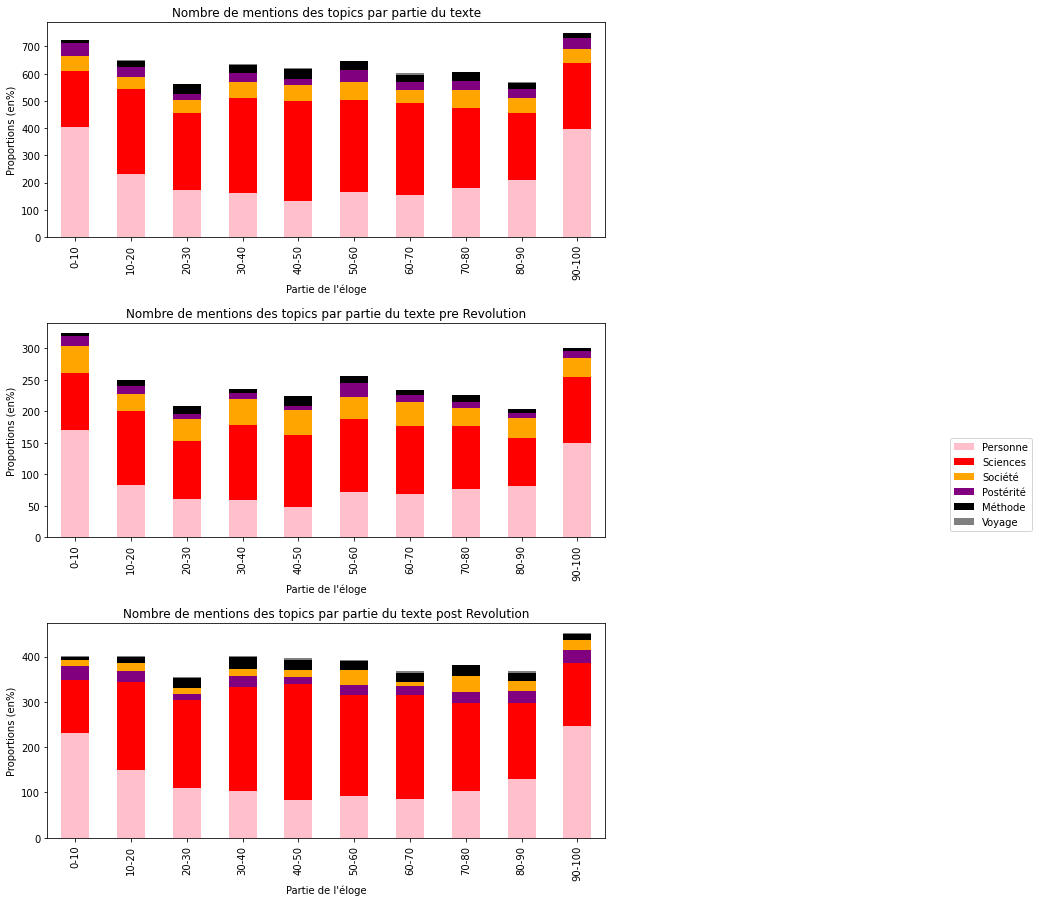

In [81]:
test,_,_ = plot_stack_bar(df_sent_hh)

144it [00:00, 21967.69it/s]
79it [00:00, 20482.79it/s]
65it [00:00, 17557.30it/s]


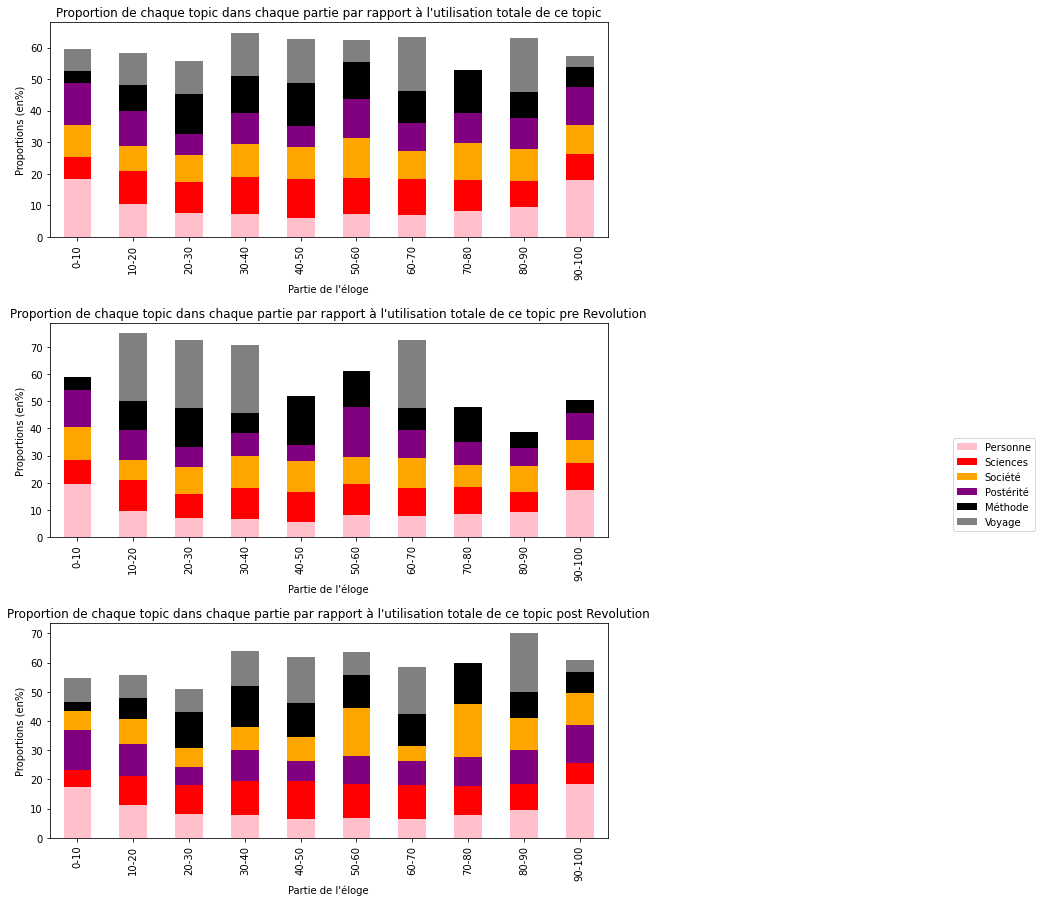

In [82]:
test,_,_ = plot_stack_bar(df_sent_hh, norm_by_tot=True)

Travel is more mentionned throughout the entire text after the Revolution and posterity is more regular after the Revolution

144it [00:00, 21364.69it/s]
79it [00:00, 22091.47it/s]
65it [00:00, 17643.66it/s]


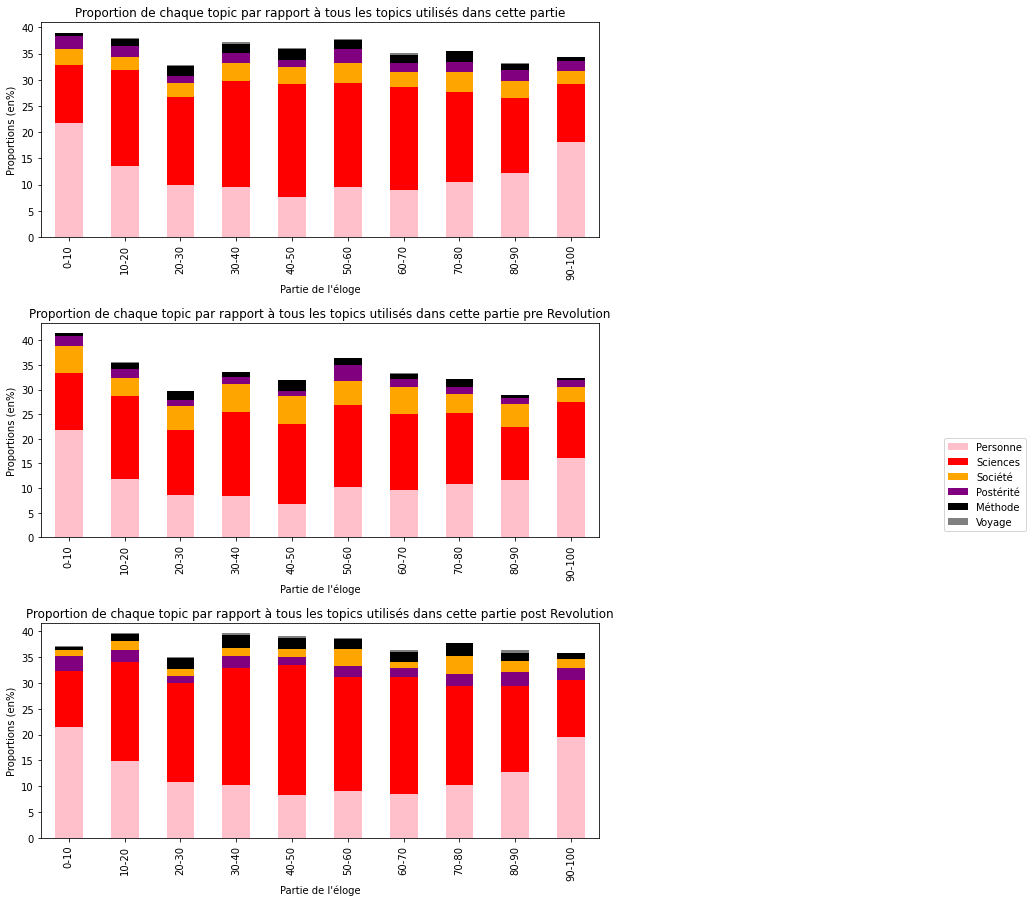

In [83]:
_,_,_ = plot_stack_bar(df_sent_hh, norm = True)

Science takes a more important place after the Revolution whereas society is less mentionned.

Travel is only mentionned after the Revolution

## Vie

In [85]:
df_vie = df_sent_t.copy()
df_vie['Topic_Ordered'] = df_vie['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_vie])

144it [00:00, 23560.75it/s]
79it [00:00, 18566.15it/s]
65it [00:00, 19532.15it/s]


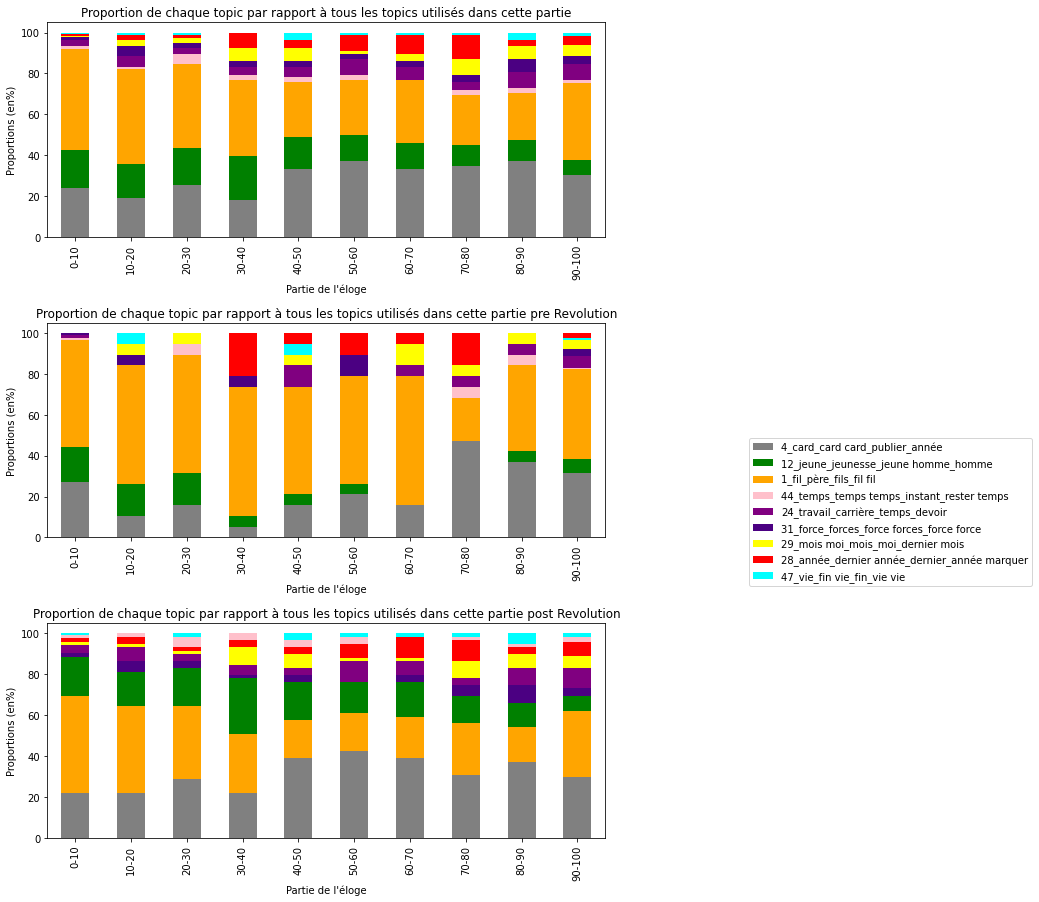

In [86]:
color_p = {'4_card_card card_publier_année' : 'grey', '12_jeune_jeunesse_jeune homme_homme' : 'green', '1_fil_père_fils_fil fil' :
          'orange', '44_temps_temps temps_instant_rester temps' : 'pink', '24_travail_carrière_temps_devoir' : 'purple',
          '29_mois moi_mois_moi_dernier mois' : 'yellow', '28_année_dernier année_dernier_année marquer' : 'red',
          '47_vie_fin vie_fin_vie vie' : 'cyan', '31_force_forces_force forces_force force' : 'indigo'}

_,_,_= plot_stack_bar(df_vie, keep_outliers = True, color_plot = color_p, norm = True)

We speak more about the family before the Revolution, whereas the youth is a lot more mentionned after the Revolution.
The end of life is more mentionned throughout the entire eulogy after the Revolution whereas before it is only mentionned after the 30%

## Représentation

In [87]:
df_rep = df_sent_t.copy()
df_rep['Topic_Ordered'] = df_rep['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_perso])

144it [00:00, 25867.48it/s]
79it [00:00, 23779.96it/s]
65it [00:00, 20524.71it/s]


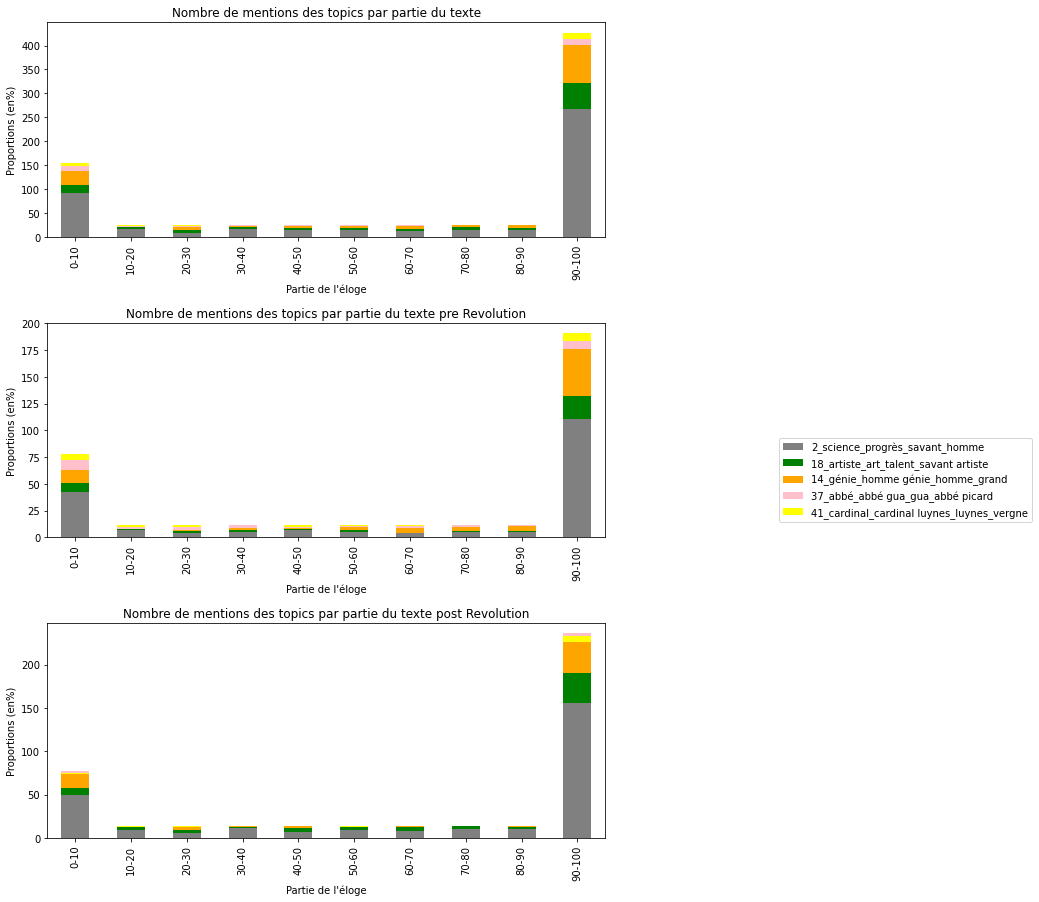

In [88]:
color_p = {'2_science_progrès_savant_homme' : 'grey', '18_artiste_art_talent_savant artiste' : 'green', 
           '14_génie_homme génie_homme_grand' :'orange', '37_abbé_abbé gua_gua_abbé picard' : 'pink', 
           '24_travail_carrière_temps_devoir' : 'purple', '41_cardinal_cardinal luynes_luynes_vergne' : 'yellow'}

_,_,_= plot_stack_bar(df_rep, keep_outliers = True, color_plot = color_p)

No big difference between after and before the Revolution

144it [00:00, 26067.32it/s]
79it [00:00, 22918.11it/s]
65it [00:00, 21089.95it/s]


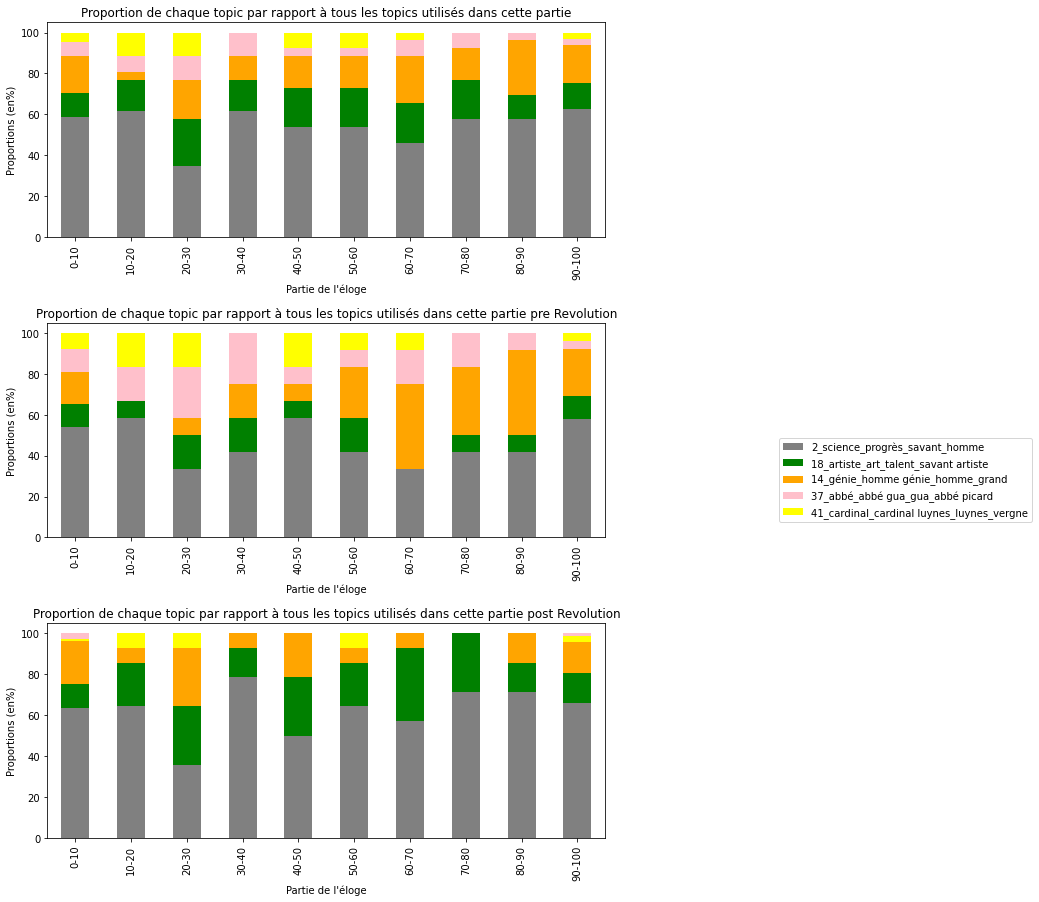

In [89]:
_,_,_= plot_stack_bar(df_rep, keep_outliers = True, color_plot = color_p, norm=True)

- A lot more of topic 2 science throuhgout the entire eulogy after the Revolution, more than 60% alomost always
- More of topic 18 after the Revolution throughout the entire text
- Topic 32 more present before the Revolution throughout the entire eulogy same for topic 41

## Politique & Religion

In [90]:
df_pol = df_sent_t.copy()
df_pol['Topic_Ordered'] = df_pol['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_societe])

144it [00:00, 26200.75it/s]
79it [00:00, 23887.97it/s]
65it [00:00, 19888.37it/s]


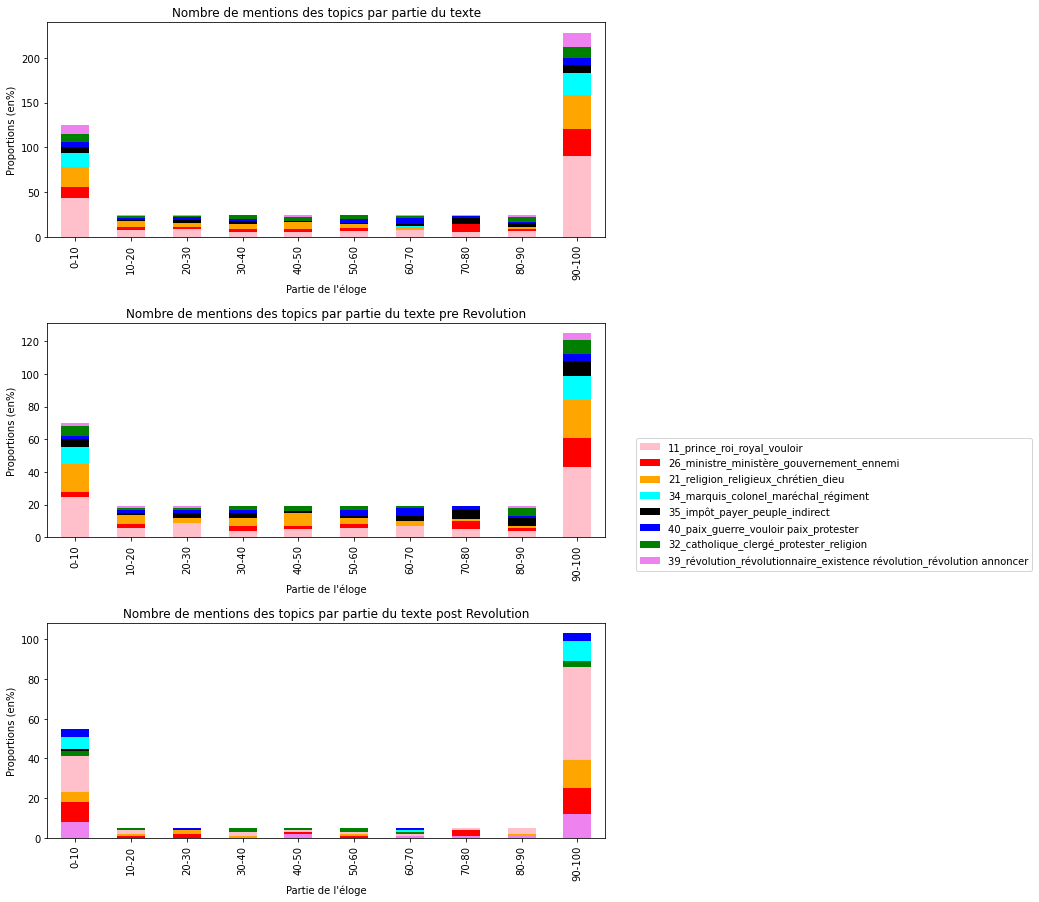

In [91]:
color_p = {'11_prince_roi_royal_vouloir' : 'pink', '26_ministre_ministère_gouvernement_ennemi' : 'red',
          '21_religion_religieux_chrétien_dieu' : 'orange', '35_impôt_payer_peuple_indirect' : 'black',
          '40_paix_guerre_vouloir paix_protester' : 'blue', '32_catholique_clergé_protester_religion' : 'green',
          '39_révolution_révolutionnaire_existence révolution_révolution annoncer' : 'violet', 
          '34_marquis_colonel_maréchal_régiment' : 'cyan'}

_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = False)

Politique plus évoquée tout le long de l'éloge avant la révolution, particulièrement loi peuple nation pas hasard chancelier occuper perdre

144it [00:00, 26190.53it/s]
79it [00:00, 23694.94it/s]
65it [00:00, 21334.20it/s]


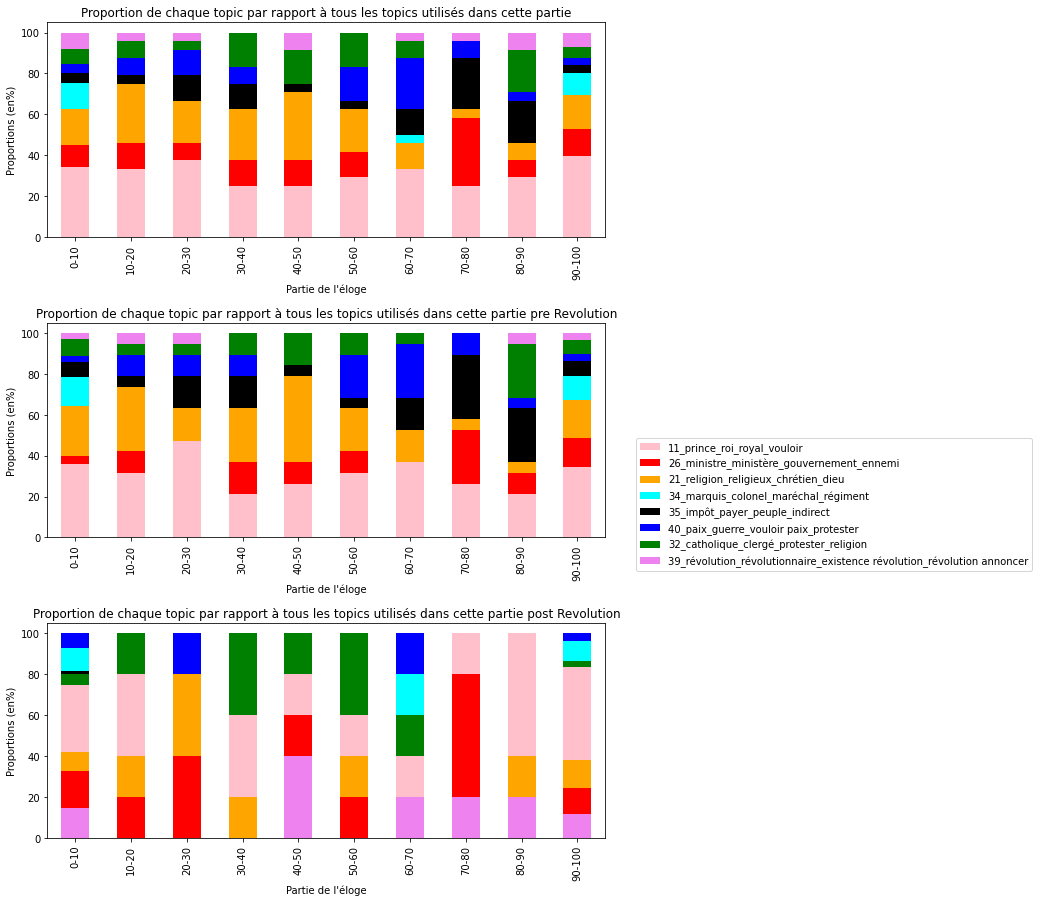

In [92]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = True)

The Revolution is more evocked after the Revolution thourhout the whole eulogy mainly towards the second part. 

The taxes are more mentionned before the Revolution.

The religion is evocked thourhgout the entire eulogy before the Revolution whereas after it is more in the middle and a bit at the beginning. 

The peace is evocked throughout the entire eulogy before the Revolution whereas after it is only in the first 10 percent and 20-30 and 60-70.

144it [00:00, 26603.52it/s]
79it [00:00, 25749.92it/s]
65it [00:00, 24685.78it/s]


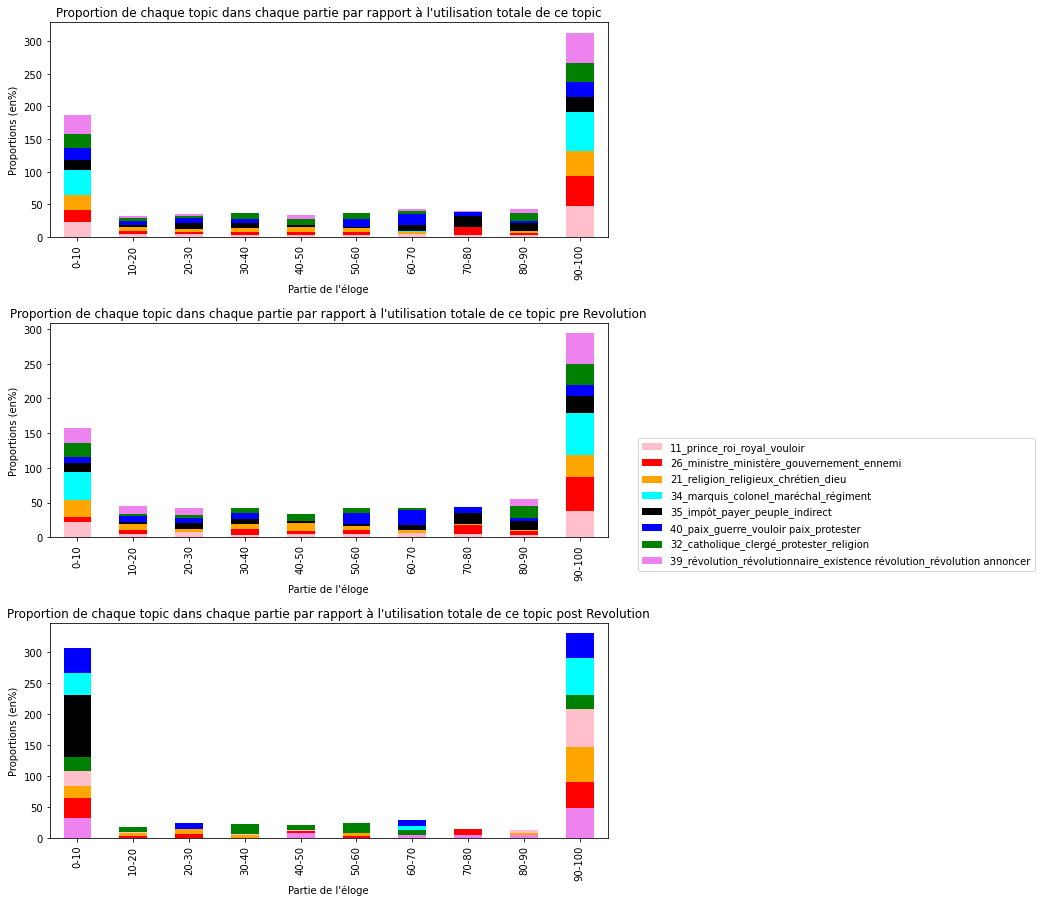

In [93]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Posterite

In [94]:
df_pos = df_sent_t.copy()
df_pos['Topic_Ordered'] = df_pos['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_posterite])

144it [00:00, 26185.99it/s]
79it [00:00, 23566.86it/s]
65it [00:00, 21906.77it/s]


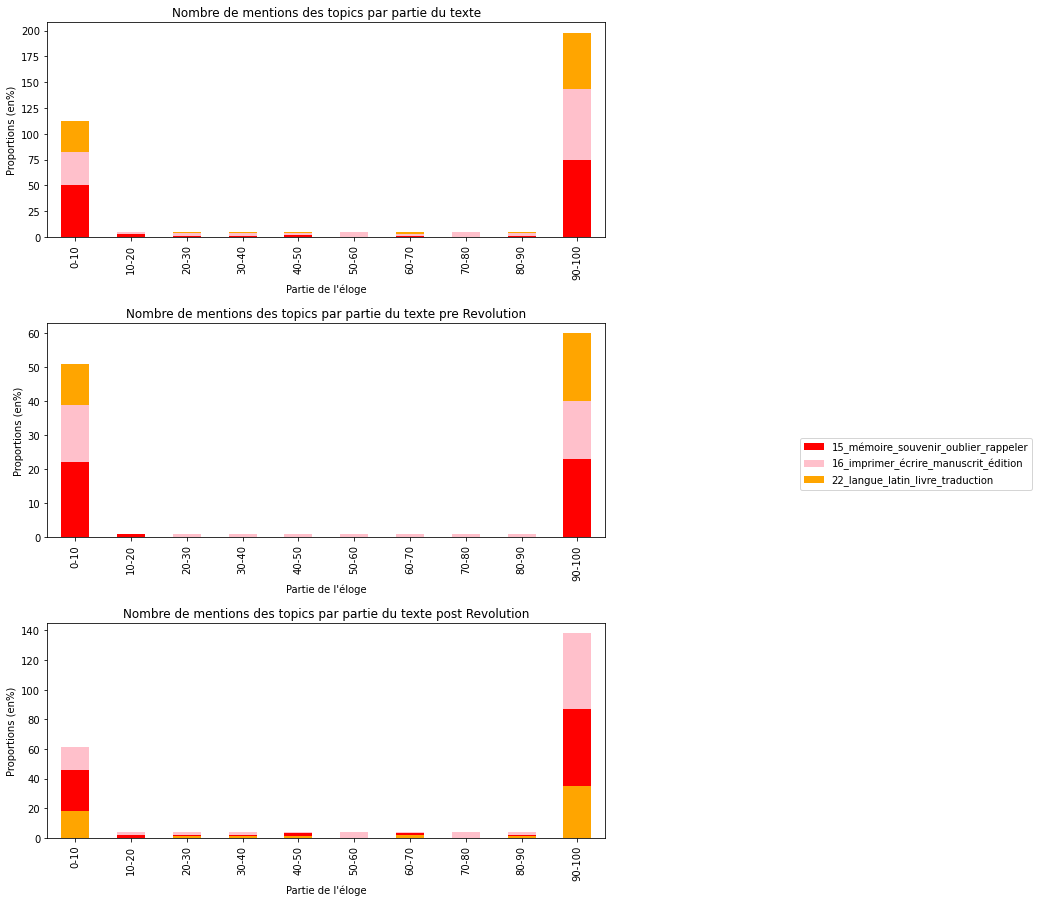

In [95]:
color_p = {'15_mémoire_souvenir_oublier_rappeler' : 'red', '16_imprimer_écrire_manuscrit_édition' : 'pink',
         '22_langue_latin_livre_traduction' : 'orange'}

_,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p)

144it [00:00, 26296.58it/s]
79it [00:00, 23723.78it/s]
65it [00:00, 19567.20it/s]


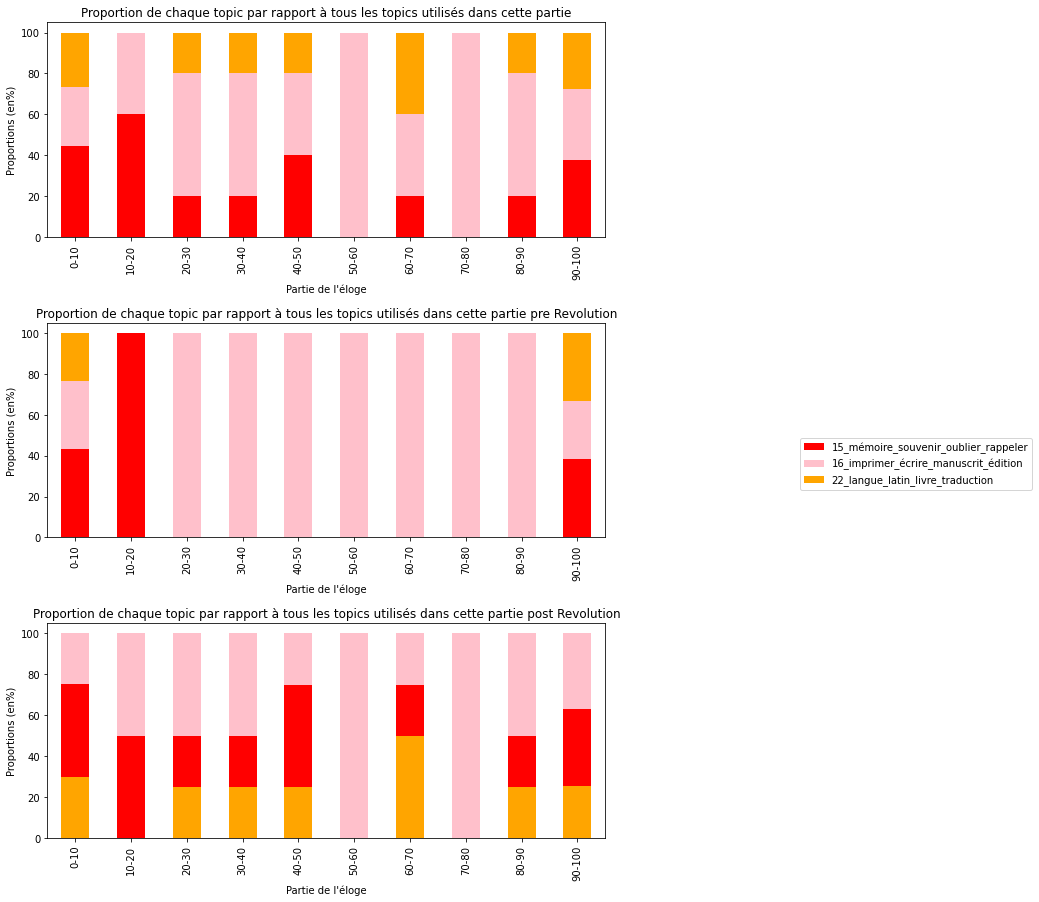

In [96]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm = True)

The languages are more evocked after Revolution throughout the entire eulogy, whereas before it is only in the first 10 percent or last ones. 

Same for memory that is the totality of the 10-20 percent before the Revolution whereas after it is thoughout the entire eulogy

Avant la révolution postérité discutée qu'au début et à la fin de l'éloge par rapport à après la Révolution

144it [00:00, 26306.89it/s]
79it [00:00, 24047.46it/s]
65it [00:00, 20759.14it/s]


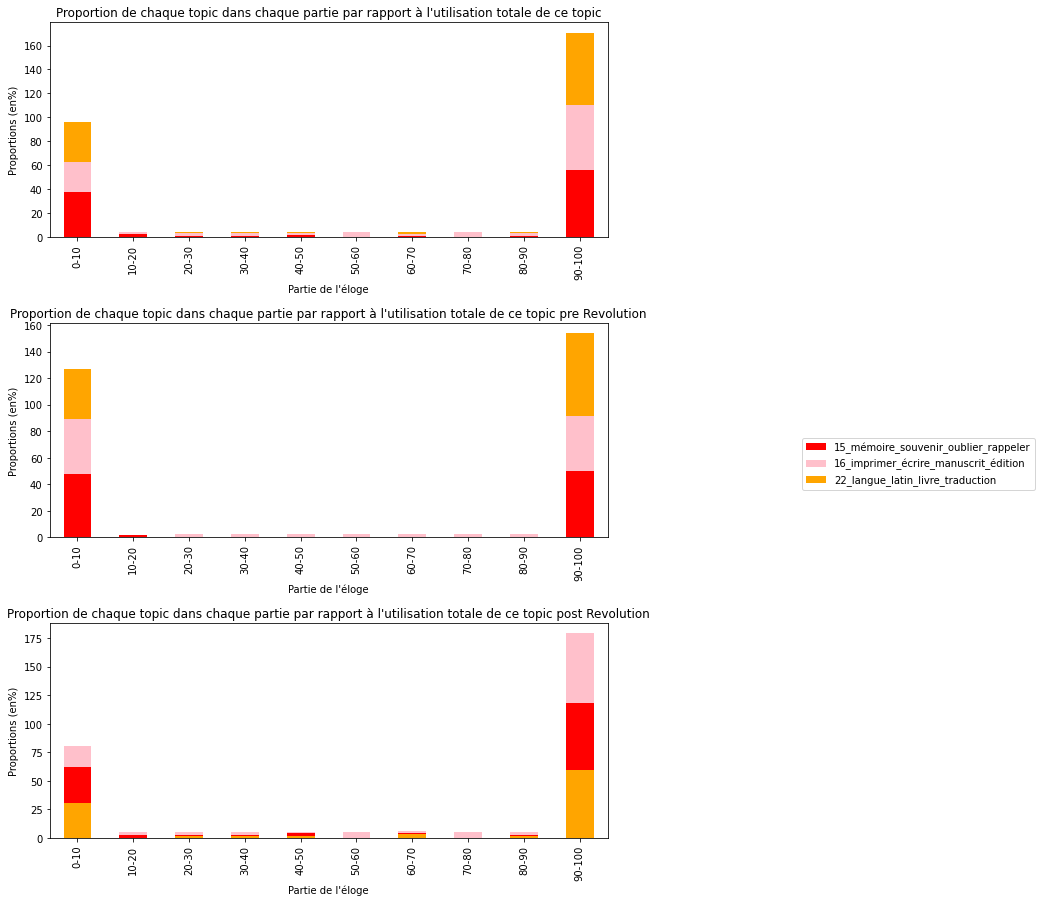

In [97]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Science

In [98]:
df_disc = df_sent_h.copy()
df_disc['Topic_Ordered'] = df_disc['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_science])

144it [00:00, 24185.31it/s]
79it [00:00, 22373.40it/s]
65it [00:00, 22436.82it/s]


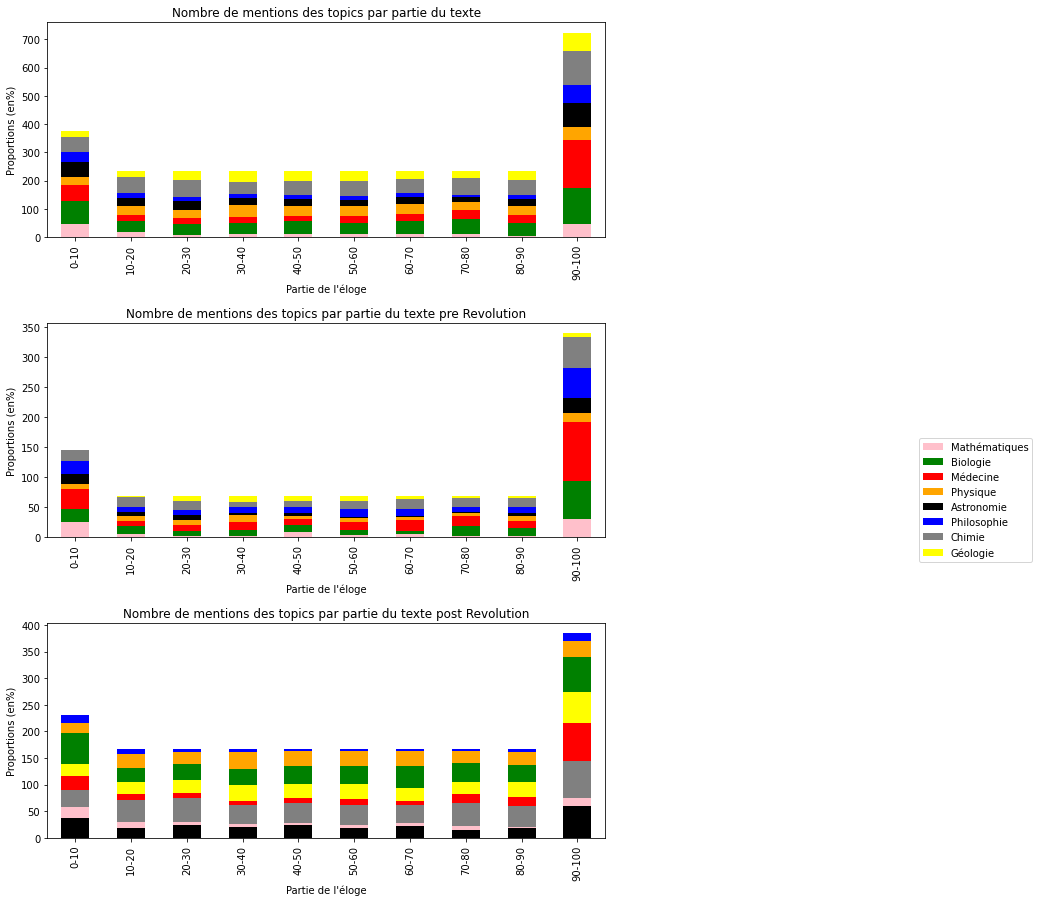

In [99]:
color_p = {'Mathématiques'  : 'pink', 'Médecine' : 'red', 'Biologie' : 'green', 'Philosophie' : 'blue',
          'Astronomie' : 'black', 'Physique' :'orange', 'Méthode' : 'violet', 'Chimie' :
          'grey', 'Géologie' : 'yellow'}

perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

The science is more present in the text after the Revolution than before

144it [00:00, 24578.00it/s]
79it [00:00, 22687.44it/s]
65it [00:00, 18253.20it/s]


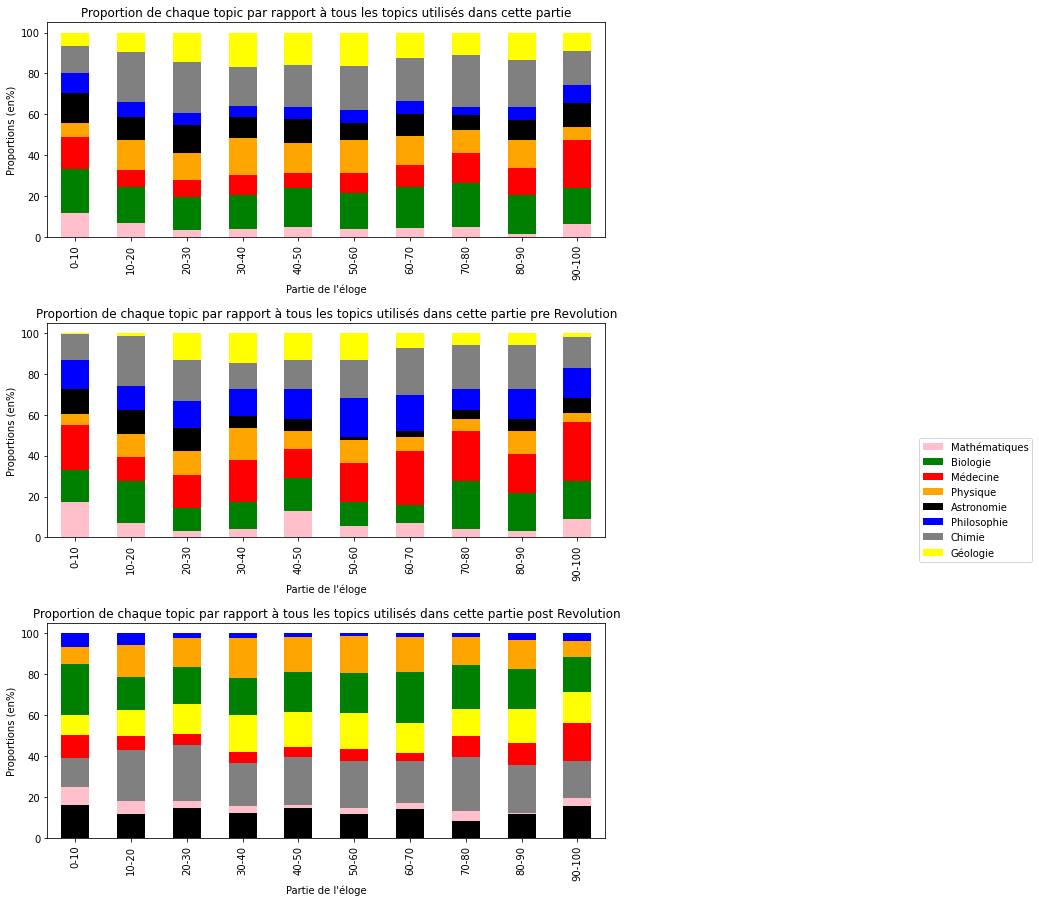

In [100]:
 perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p, norm=True)

- We see that philosophy is more present before the Revolution.
- Mathematics a bit more present before the Revolution
- Biology looks lije it's the same
- Physics as well
- Astronomy more present after the Revolution
- Chemistry a bit more present as well
- Geology more present after the Revolution

## Theorie

In [101]:
df_theo = df_sent_t.copy()
df_theo['Topic_Ordered'] = df_theo['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_methode])

144it [00:00, 26548.56it/s]
79it [00:00, 24210.87it/s]
65it [00:00, 22898.52it/s]


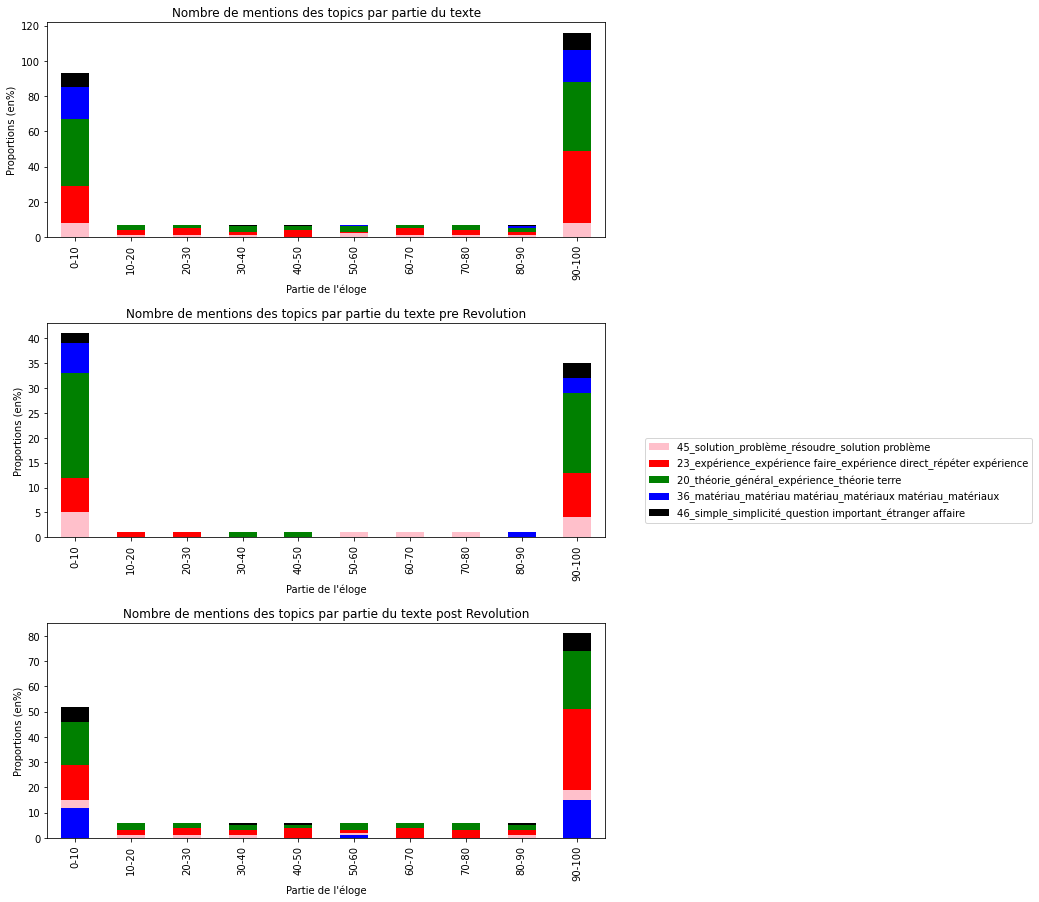

In [102]:
color_p = {'45_solution_problème_résoudre_solution problème'  : 'pink', 
           '23_expérience_expérience faire_expérience direct_répéter expérience' : 'red', 
           '20_théorie_général_expérience_théorie terre' : 'green', 
           '36_matériau_matériau matériau_matériaux matériau_matériaux' : 'blue',
          '46_simple_simplicité_question important_étranger affaire' : 'black'}

perc,_,_ = plot_stack_bar(df_theo, keep_outliers = True, color_plot = color_p)

Method presence is approximately the same before and after the Revolution

144it [00:00, 26651.65it/s]
79it [00:00, 22661.06it/s]
65it [00:00, 19834.83it/s]


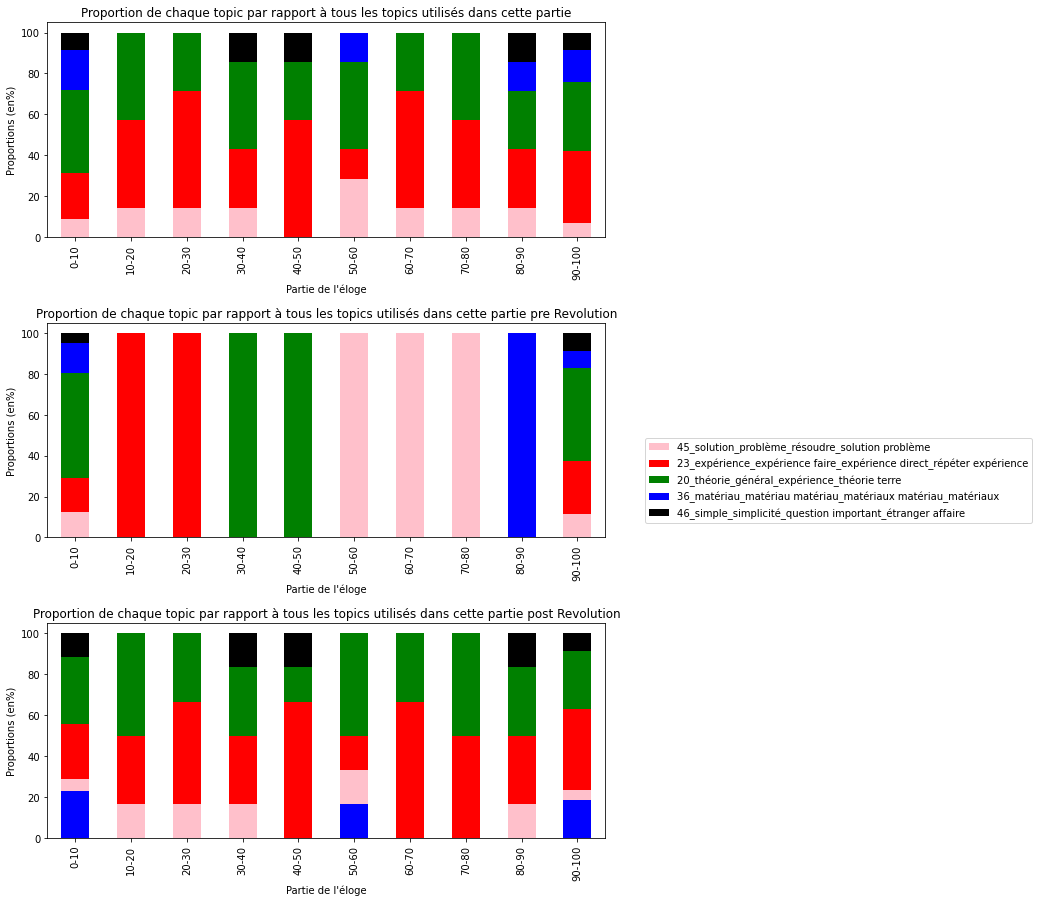

In [103]:
perc,_,_ = plot_stack_bar(df_theo, keep_outliers = True, color_plot = color_p, norm=True)

- 10-30 is only occupied by the experience before the revolution 
- 30-40 only occupied by theorie
- 50-80 only occupied by solution problem solve
- 80-90 by mterial

After the Revolution it is more diversed each part of the text

## Voyage

144it [00:00, 24869.46it/s]
79it [00:00, 21367.77it/s]
65it [00:00, 20879.97it/s]


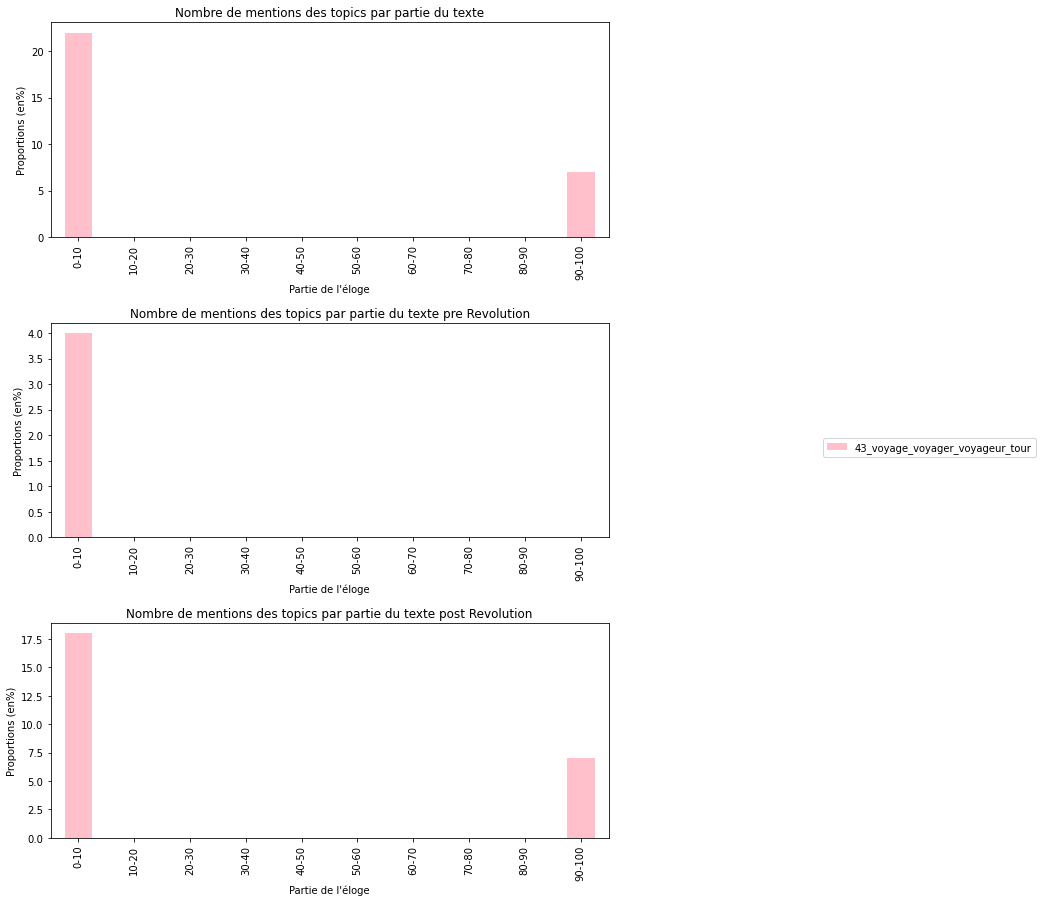

In [104]:
df_voy = df_sent_t.copy()
df_voy['Topic_Ordered'] = df_voy['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_voyage])

color_p = {'43_voyage_voyager_voyageur_tour'  : 'pink', '30_île_bougainville_visiter_côte' : 'red'}

perc,_,_ = plot_stack_bar(df_voy, keep_outliers = True, color_plot = color_p, norm = False)

Travel more mentionned after the Revolution and only at the beginning and end of text
